In [49]:
import pandas as pd

df1 = pd.read_csv('positive.csv', na_values=['NULL'])

df2 = pd.read_csv('negative.csv', na_values=['NULL'])

df = pd.concat([df1, df2], ignore_index=True)

df['AcquisitionDateTime_DT'] = pd.to_datetime(df['AcquisitionDateTime_DT'])

print(df.head())

print(df.info())
print(df.isnull().sum())

  PatientID                              12SL_Codes Source  \
0   HR00008       22,542,1665,533,1666,780,831,1699  PTBXL   
1   HR00077                         22,964,821,1699  PTBXL   
2   HR00085  22,542,1665,531,1666,1682,740,831,1699  PTBXL   
3   HR00103                     23,470,780,831,1699  PTBXL   
4   HR00128                    22,1682,780,831,1699  PTBXL   

                                          Phys_Codes  MI_12SL  MI_Phys  \
0          164865005, 164951009, 39732003, 426783006        1        1   
1                     426783006, 54329005, 713426002        1        1   
2                                          426783006        1        0   
3  164865005, 164951009, 39732003, 427084000, 445...        1        1   
4                                          164934002        1        0   

   TestID  PatientAge  Gender AcquisitionDateTime_DT  ...  STDOWN_V6  \
0       8         NaN     NaN    2020-04-23 07:59:54  ...          0   
1      77         NaN     NaN    2020-

In [50]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


In [51]:
from sklearn.model_selection import train_test_split
import pandas as pd

y = df["MI_Phys"]

analysis_codes_fn = ['HR00039', 'HR00162', 'HR00274', 'HR00282', 'HR00308']
analysis_codes_fp = ['HR00085', 'HR00128', 'HR00222', 'HR00265', 'HR00527', 'HR00529', 'HR00855', 'HR00994', 'HR00995', 'HR01026', 'HR01528', 'HR02158', 'HR04251', 'HR04274', 'HR04841', 'HR04986', 'HR04986', 'HR05233', 'HR06205', 'HR08265', 'HR10943', 'HR11886', 'JS00403', 'Q0012', 'Q0016']

df_fn_records = df[df['PatientID'].isin(analysis_codes_fn)]
df_fp_records = df[df['PatientID'].isin(analysis_codes_fp)]

df_fn_records_clean = df_fn_records.drop(columns=["12SL_Codes", "MI_12SL","Phys_Codes", "TestID", "Source",
                                                  "Gender", "PatientAge", "AcquisitionDateTime_DT", "MI_Phys", "POffset", "PAxis", "POnset"])
df_fp_records_clean = df_fp_records.drop(columns=["12SL_Codes", "MI_12SL","Phys_Codes", "TestID", "Source",
                                                  "Gender", "PatientAge", "AcquisitionDateTime_DT", "MI_Phys", "POffset", "PAxis", "POnset"])

X = df.drop(columns=["PatientID", "12SL_Codes", "Phys_Codes", "TestID", "Source", 
                     "Gender", "PatientAge", "AcquisitionDateTime_DT", "MI_Phys", "POffset", "PAxis", "POnset"])

#drop columns that include "P_", "Full", "Rate"

X = X.loc[:, ~X.columns.str.contains('P_')]
X = X.loc[:, ~X.columns.str.contains('Full')]
X = X.loc[:, ~X.columns.str.contains('Rate')]

df_fn_records_clean = df_fn_records_clean.loc[:, ~df_fn_records_clean.columns.str.contains('P_')]
df_fn_records_clean = df_fn_records_clean.loc[:, ~df_fn_records_clean.columns.str.contains('Full')]
df_fn_records_clean = df_fn_records_clean.loc[:, ~df_fn_records_clean.columns.str.contains('Rate')]

df_fp_records_clean = df_fp_records_clean.loc[:, ~df_fp_records_clean.columns.str.contains('P_')]
df_fp_records_clean = df_fp_records_clean.loc[:, ~df_fp_records_clean.columns.str.contains('Full')]
df_fp_records_clean = df_fp_records_clean.loc[:, ~df_fp_records_clean.columns.str.contains('Rate')]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Save the original algorithm's prediction for test set before dropping it
y_12SL = X_test["MI_12SL"]

# Split data based on MI_12SL classification
X_train_pos = X_train[X_train["MI_12SL"] == 1].drop(columns=["MI_12SL"])
X_train_neg = X_train[X_train["MI_12SL"] == 0].drop(columns=["MI_12SL"])
X_test_pos = X_test[X_test["MI_12SL"] == 1].drop(columns=["MI_12SL"])
X_test_neg = X_test[X_test["MI_12SL"] == 0].drop(columns=["MI_12SL"])

# Ensure y labels match the correct samples
y_train_pos = y_train.loc[X_train_pos.index]  # True positives or false positives
y_train_neg = y_train.loc[X_train_neg.index]  # True negatives or false negatives
y_test_pos = y_test.loc[X_test_pos.index]
y_test_neg = y_test.loc[X_test_neg.index]

X_train = X_train.drop(columns=["MI_12SL"])
X_test = X_test.drop(columns=["MI_12SL"])

# Extract MI_12SL predictions
y_12SL_pos = y_12SL.loc[X_test_pos.index]  # Original classifier's labels
y_12SL_neg = y_12SL.loc[X_test_neg.index]


In [52]:
# output features name list
features = X_train.columns.tolist()
print(len(features))
features

480


['QRSDuration',
 'Q_TInterval',
 'QTCCalculation',
 'QTcFredericia',
 'QTcFramingham',
 'QTc_Bazett',
 'QOnset',
 'QOffset',
 'TOffset',
 'RAxis',
 'TAxis',
 'ECGSampleBase',
 'Q_PeakAmpl_I',
 'Q_Duration_I',
 'Q_Area_I',
 'Q_PeakTime_I',
 'R_PeakAmpl_I',
 'R_Duration_I',
 'R_Area_I',
 'R_PeakTime_I',
 'S_PeakAmpl_I',
 'S_Duration_I',
 'S_Area_I',
 'S_PeakTime_I',
 'STJ_I',
 'STM_I',
 'STE_I',
 'MaxST_I',
 'MinST_I',
 'T_Special_I',
 'QRS_Balance_I',
 'QRS_Deflection_I',
 'Max_R_Ampl_I',
 'Max_S_Ampl_I',
 'T_PeakAmpl_I',
 'T_Duration_I',
 'T_Area_I',
 'T_PeakTime_I',
 'T_End_I',
 'QRS_Area_I',
 'QRSint_I',
 'TTALL_I',
 'STDOWN_I',
 'STELEV_I',
 'JELEV_I',
 'DLTWV_I',
 'STINJ_I',
 'QRS_T_REVERSE_I',
 'QRS_ST_REVERSE_I',
 'ST_T_REVERSE_I',
 'BRUGFLG_I',
 'Q_PeakAmpl_II',
 'Q_Duration_II',
 'Q_Area_II',
 'Q_PeakTime_II',
 'R_PeakAmpl_II',
 'R_Duration_II',
 'R_Area_II',
 'R_PeakTime_II',
 'S_PeakAmpl_II',
 'S_Duration_II',
 'S_Area_II',
 'S_PeakTime_II',
 'STJ_II',
 'STM_II',
 'STE_II',
 

In [53]:
#count number of positive and negative values based on MI_Phys
print(df1['MI_Phys'].value_counts())

MI_Phys
0    5419
1    4003
Name: count, dtype: int64


In [54]:
lgb_params = {
    'objective': 'binary',
    'boosting_type': 'dart',
    'colsample_bytree': 0.9889,
    'n_estimators': 1000,
    'learning_rate': 0.0807,
    'random_state': 42,
    'verbose': -1,
    'num_leaves': 106,
    'min_child_weight': 1,
    'max_depth' : 7,
    'reg_alpha' : 0.7909,
    'reg_lambda' : 0.61348,
    'subsample' : 0.903,
    # 'metric': 'auc', 
    'scale_pos_weight': 3.537,
    'device': 'gpu',
    }
model_pos = (lgb.LGBMClassifier(**lgb_params))
model_pos.fit(X_train_pos, y_train_pos)
y_pred_pos = model_pos.predict(X_test_pos)
score = f1_score(y_test_pos, y_pred_pos, average='micro')
print("Final F1 score: ", score)

Final F1 score:  0.7822198842714361


In [55]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

X = X_train_pos
y = y_train_pos

# Hyperparameter search space
space = {
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart', 'rf']),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 10),
}

def objective(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['device'] = 'gpu'
    
    clf = lgb.LGBMClassifier(
        n_estimators=100,
        objective='binary',
        # metric='auc',
        verbose=-1,
        **params
    )
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(clf, X, y, scoring='f1', cv=cv).mean()
    
    return {'loss': 1 - score, 'status': STATUS_OK}

trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,  
    trials=trials,
    rstate=np.random.Generator(np.random.PCG64(42))
)

print("Best hyperparameters:", best)


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [05:51<00:00,  7.03s/trial, best loss: 0.23065701474609135]
Best hyperparameters: {'boosting_type': np.int64(0), 'colsample_bytree': np.float64(0.9997663083923135), 'learning_rate': np.float64(0.19590997958399192), 'max_depth': np.float64(8.0), 'min_child_weight': np.float64(9.0), 'num_leaves': np.float64(111.0), 'reg_alpha': np.float64(0.8234668997283726), 'reg_lambda': np.float64(0.5311080674250799), 'scale_pos_weight': np.float64(2.9731200313513835), 'subsample': np.float64(0.9991506829561065)}


In [56]:
#run model with the parameters from the dictionary with the model parameters from "best"
boosting_type = ['gbdt', 'dart', 'rf']
best['boosting_type'] = boosting_type[best['boosting_type']]
lgb_params = {
    'objective': 'binary',
    'boosting_type': best['boosting_type'],
    'colsample_bytree': best['colsample_bytree'],
    'n_estimators': 1000,
    'learning_rate': best['learning_rate'],
    'random_state': 42,
    'verbose': -1,
    'num_leaves': int(best['num_leaves']),
    'min_child_weight': int(best['min_child_weight']),
    'max_depth' : int(best['max_depth']),
    'reg_alpha' : best['reg_alpha'],
    'reg_lambda' : best['reg_lambda'],
    'subsample' : best['subsample'],
    # 'metric': 'auc', 
    'scale_pos_weight': best['scale_pos_weight'],
    'device': 'gpu',

    }

model_pos = (lgb.LGBMClassifier(**lgb_params))
model_pos.fit(X_train_pos, y_train_pos)
y_pred_pos = model_pos.predict(X_test_pos)
score = f1_score(y_test_pos, y_pred_pos, average='micro')
print("Final F1 score: ", score)

Final F1 score:  0.7927406628090479


In [57]:
# optuna optimization
import optuna
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np

X = X_train_pos
y = y_train_pos

def objective(trial):
    # Define the search space using trial.suggest_
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf'])
    num_leaves = trial.suggest_int('num_leaves', 20, 150)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.2, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1.0)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1.0)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    scale_pos_weight = trial.suggest_float('scale_pos_weight', 1.0, 10.0)

    clf = lgb.LGBMClassifier(
        n_estimators=500,
        objective='binary',
        boosting_type=boosting_type,
        num_leaves=num_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        min_child_weight=min_child_weight,
        scale_pos_weight=scale_pos_weight,
        verbose=-1,
        device='gpu',
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = cross_val_score(clf, X, y, scoring='f1', cv=cv)
    mean_f1 = np.mean(f1_scores)

    return 1 - mean_f1  # Optuna minimizes the objective

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, n_jobs=-1) 

print("Best trial:")
print(study.best_trial)
print("Best F1 Score:", 1 - study.best_value)
print("Best hyperparameters:", study.best_params)


[I 2025-04-11 16:28:55,684] A new study created in memory with name: no-name-a6574e88-02b1-413d-b4e4-af8c610f4151
[I 2025-04-11 16:30:20,785] Trial 18 finished with value: 0.2526803018257979 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'max_depth': 3, 'learning_rate': 0.07379897911858599, 'subsample': 0.6021675975879638, 'colsample_bytree': 0.9410917439095869, 'reg_alpha': 0.8004514977460286, 'reg_lambda': 0.013522365762416388, 'min_child_weight': 3, 'scale_pos_weight': 5.527095480077506}. Best is trial 18 with value: 0.2526803018257979.
[I 2025-04-11 16:30:23,052] Trial 12 finished with value: 0.2881523527248373 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 3, 'learning_rate': 0.008889173350800956, 'subsample': 0.7226462476991765, 'colsample_bytree': 0.7582380335518402, 'reg_alpha': 0.021184224170974986, 'reg_lambda': 0.738270453263084, 'min_child_weight': 8, 'scale_pos_weight': 2.776611657082127}. Best is trial 18 with value: 0.25268030182579

Best trial:
FrozenTrial(number=42, state=1, values=[0.2255201303567117], datetime_start=datetime.datetime(2025, 4, 11, 16, 36, 26, 816006), datetime_complete=datetime.datetime(2025, 4, 11, 16, 43, 40, 99978), params={'boosting_type': 'gbdt', 'num_leaves': 53, 'max_depth': 8, 'learning_rate': 0.04946789116397677, 'subsample': 0.6066764628421406, 'colsample_bytree': 0.8241511577391277, 'reg_alpha': 0.38746037271496075, 'reg_lambda': 0.23727418104071005, 'min_child_weight': 1, 'scale_pos_weight': 3.542417201551619}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'boosting_type': CategoricalDistribution(choices=('gbdt', 'dart', 'rf')), 'num_leaves': IntDistribution(high=150, log=False, low=20, step=1), 'max_depth': IntDistribution(high=15, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=True, low=0.005, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=

In [58]:
#run model with optuna best params

lgb_params = {
    'objective': 'binary',
    'boosting_type': study.best_params['boosting_type'],
    'colsample_bytree': study.best_params['colsample_bytree'],
    'n_estimators': 1000,
    'learning_rate': study.best_params['learning_rate'],
    'random_state': 42,
    'verbose': -1,
    'num_leaves': int(study.best_params['num_leaves']),
    'min_child_weight': int(study.best_params['min_child_weight']),
    'max_depth' : int(study.best_params['max_depth']),
    'reg_alpha' : study.best_params['reg_alpha'],
    'reg_lambda' : study.best_params['reg_lambda'],
    'subsample' : study.best_params['subsample'],
    # 'metric': 'auc', 
    'scale_pos_weight': study.best_params['scale_pos_weight'],
    'device': 'gpu',
}

model_pos = (lgb.LGBMClassifier(**lgb_params))
model_pos.fit(X_train_pos, y_train_pos)
y_pred_pos = model_pos.predict(X_test_pos)
score = f1_score(y_test_pos, y_pred_pos, average='micro')
print("Final F1 score: ", score)

Final F1 score:  0.7927406628090479


In [59]:
import shap

# Use the same background sample from your training set
background = X_train_pos.sample(100, random_state=42)

explainer = shap.TreeExplainer(
    model_pos,
    data=background,
    model_output='probability',
    feature_perturbation='interventional'
)

# Generate SHAP values for your specific records
# shap_values_fn_specific = explainer.shap_values(df_fn_records_clean.drop(columns=["PatientID"]))
shap_values_fp_specific = explainer.shap_values(df_fp_records_clean.drop(columns=["PatientID"]))


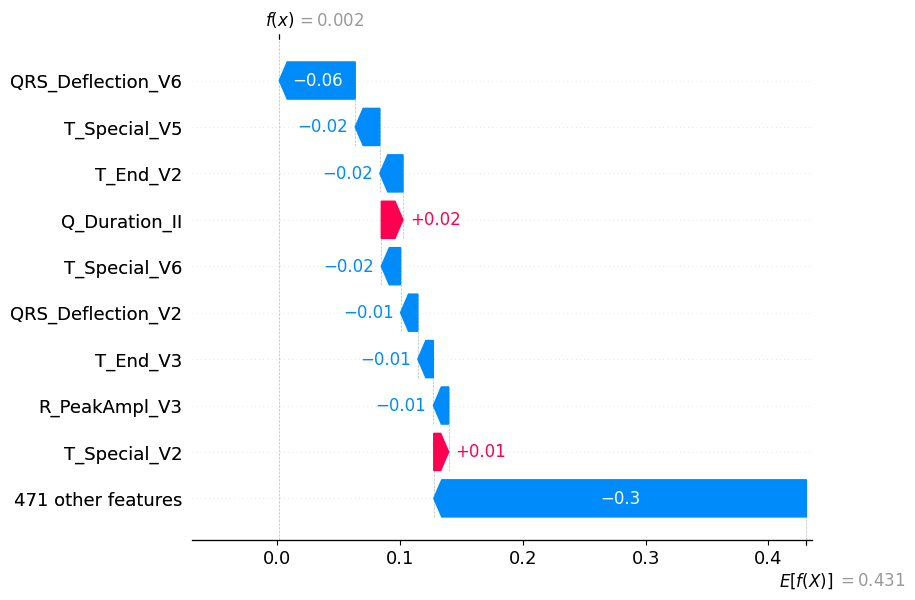

In [60]:
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values_fp_specific[0],
    feature_names=df_fp_records_clean.drop(columns=['PatientID']).columns
)


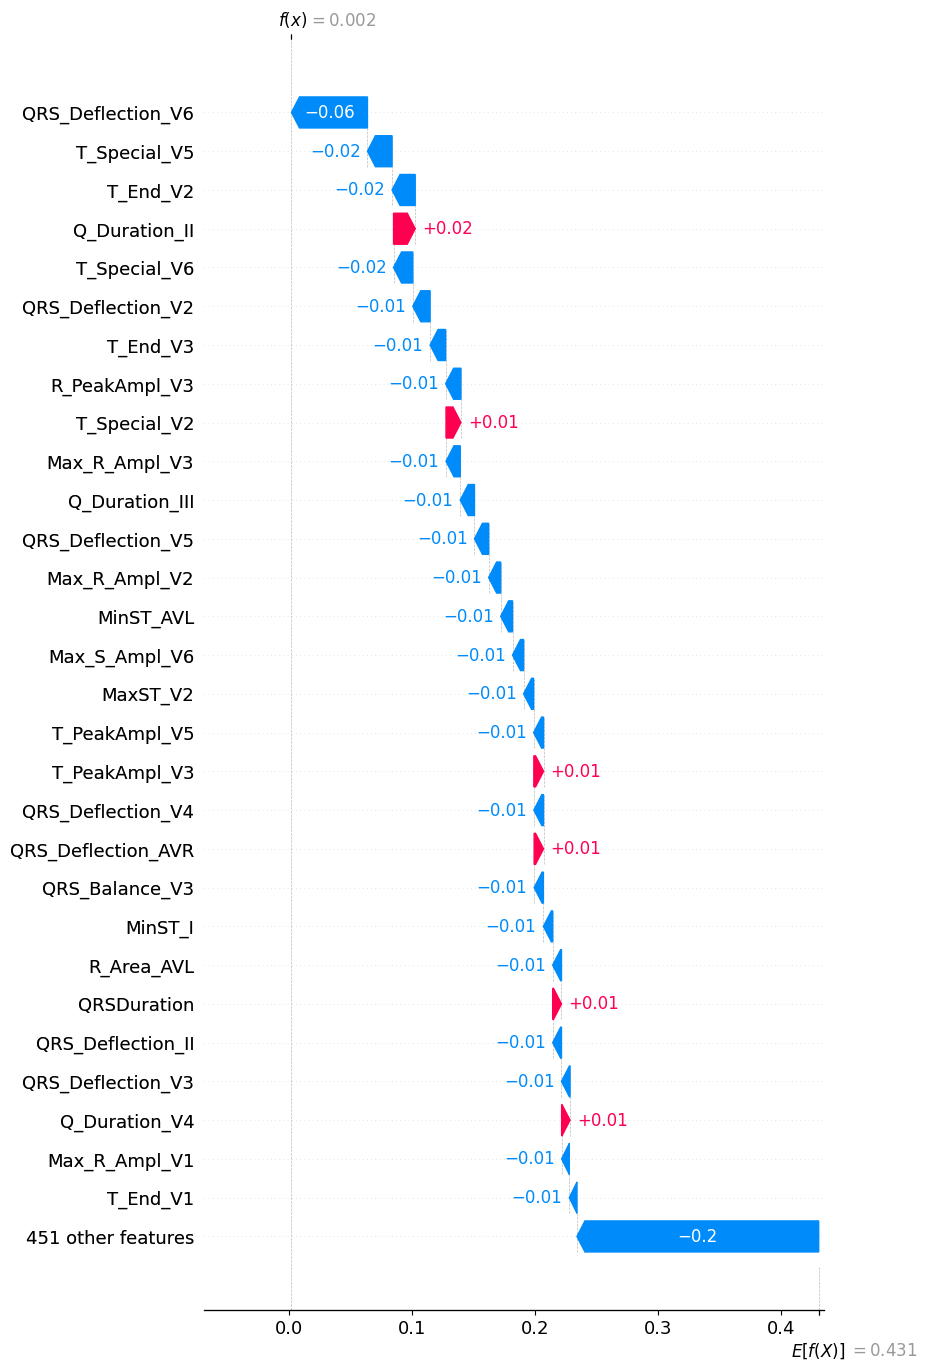

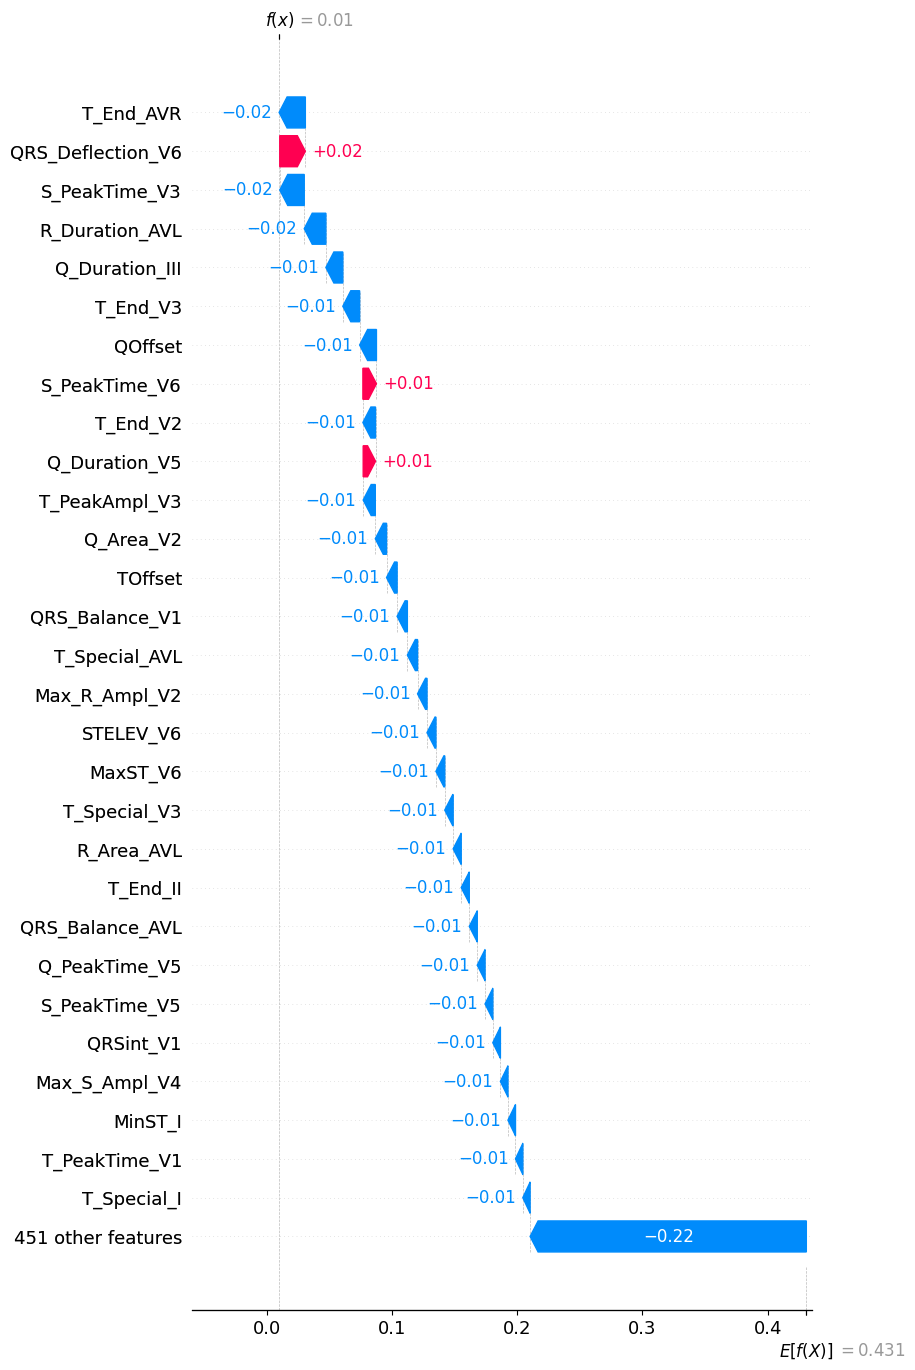

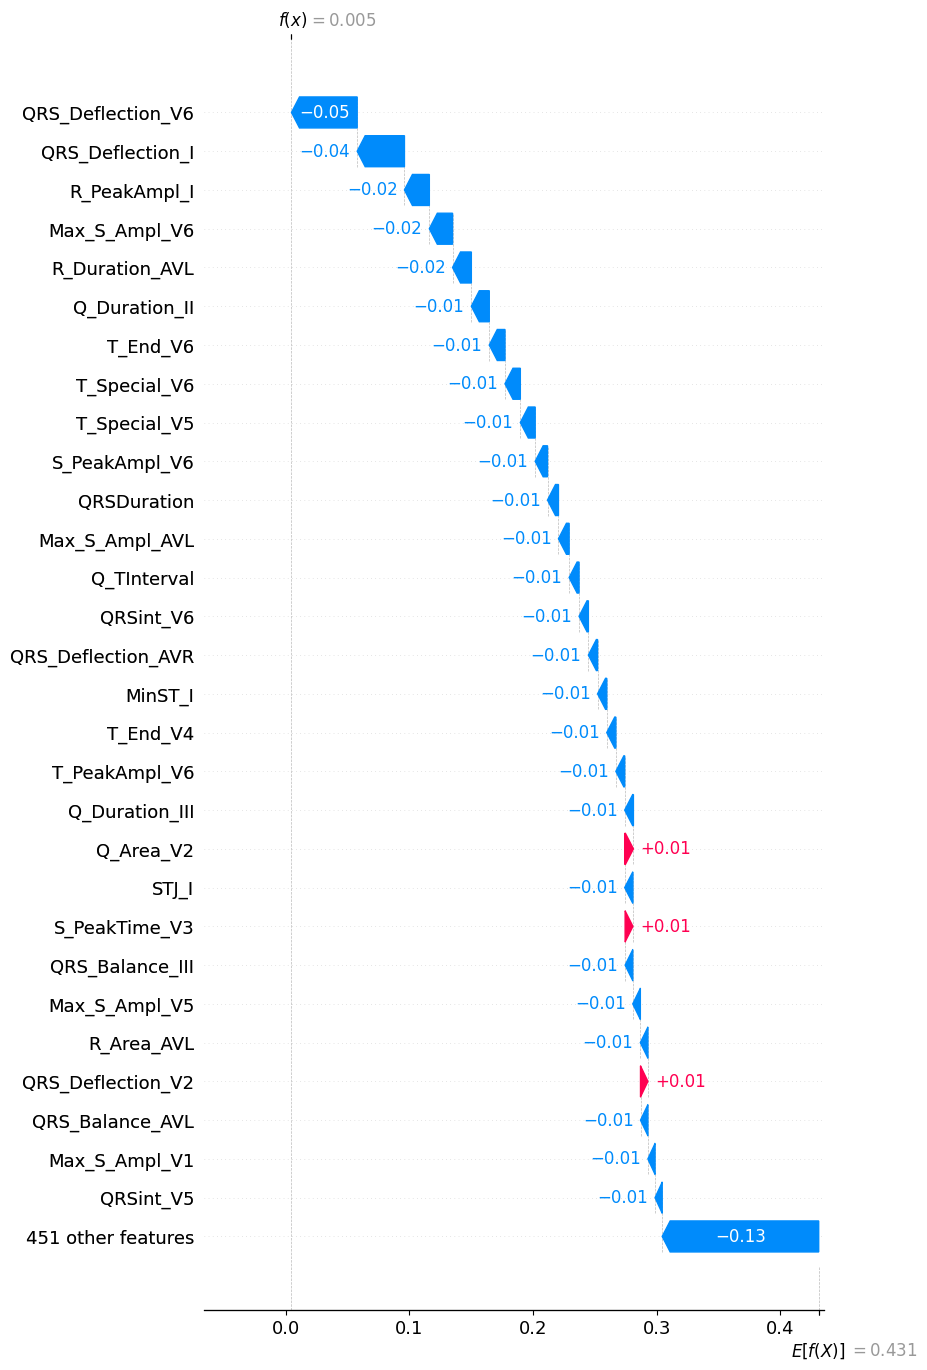

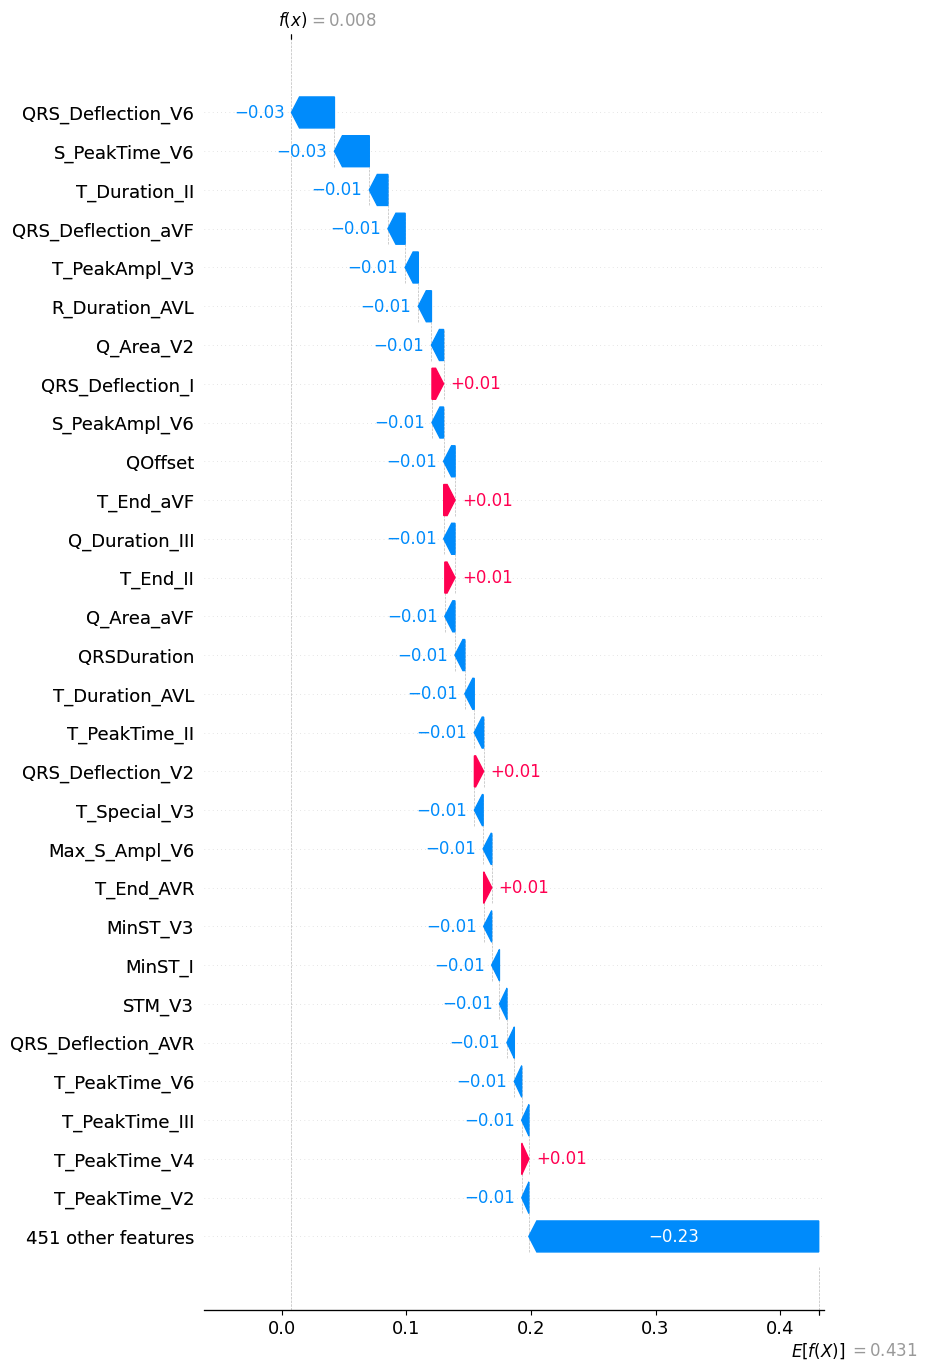

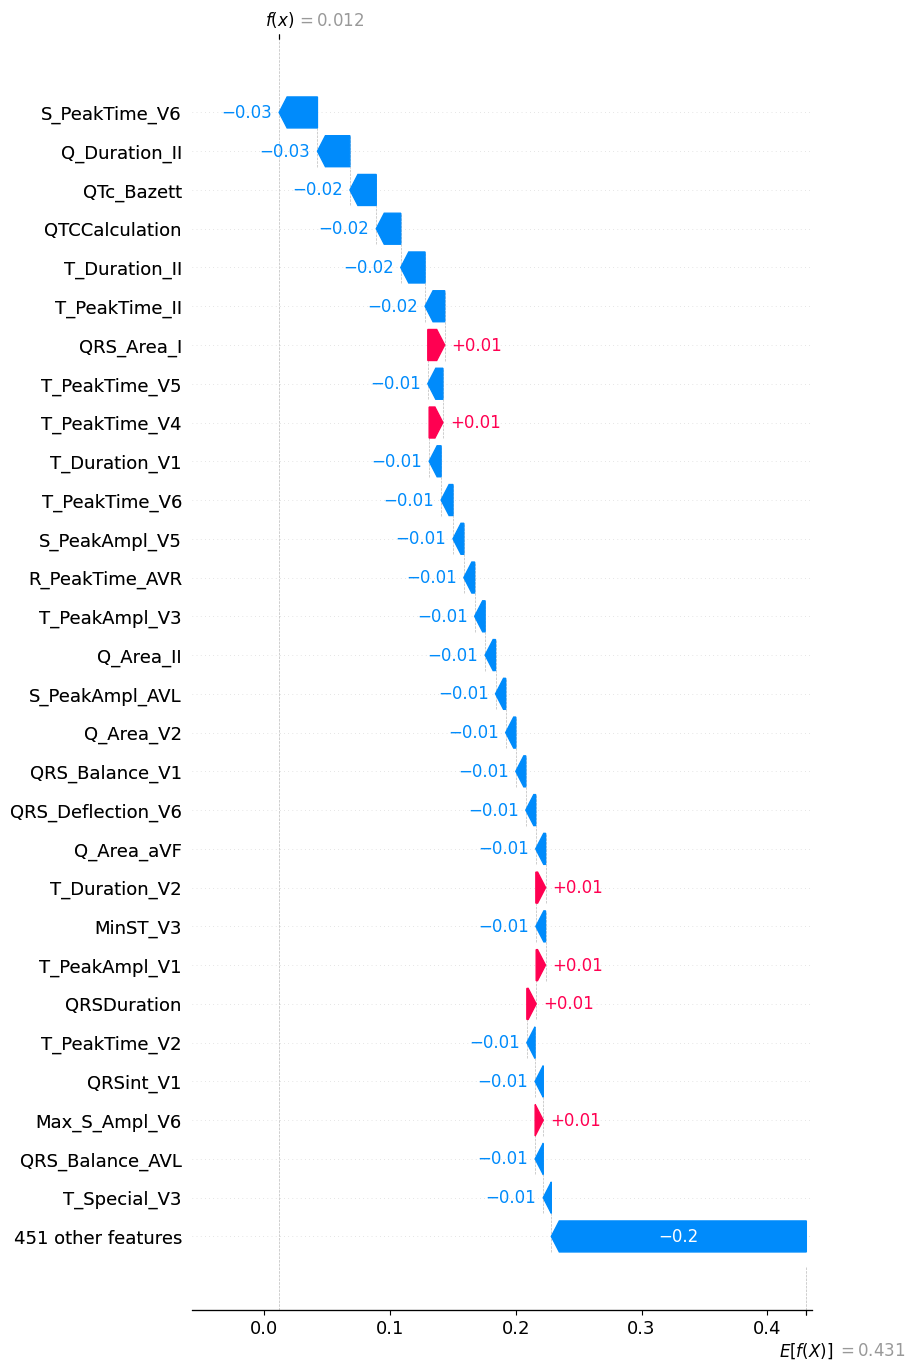

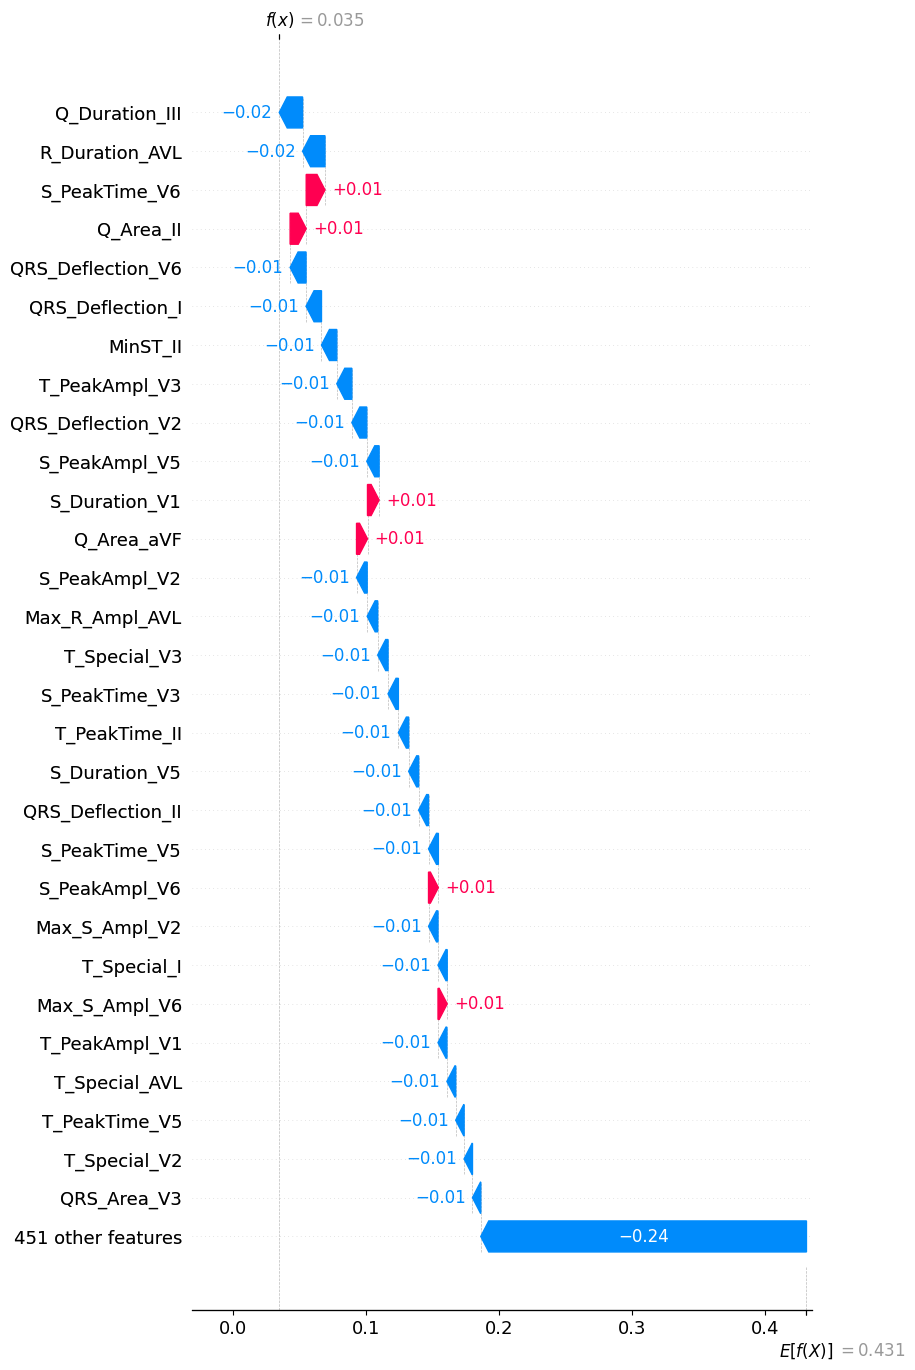

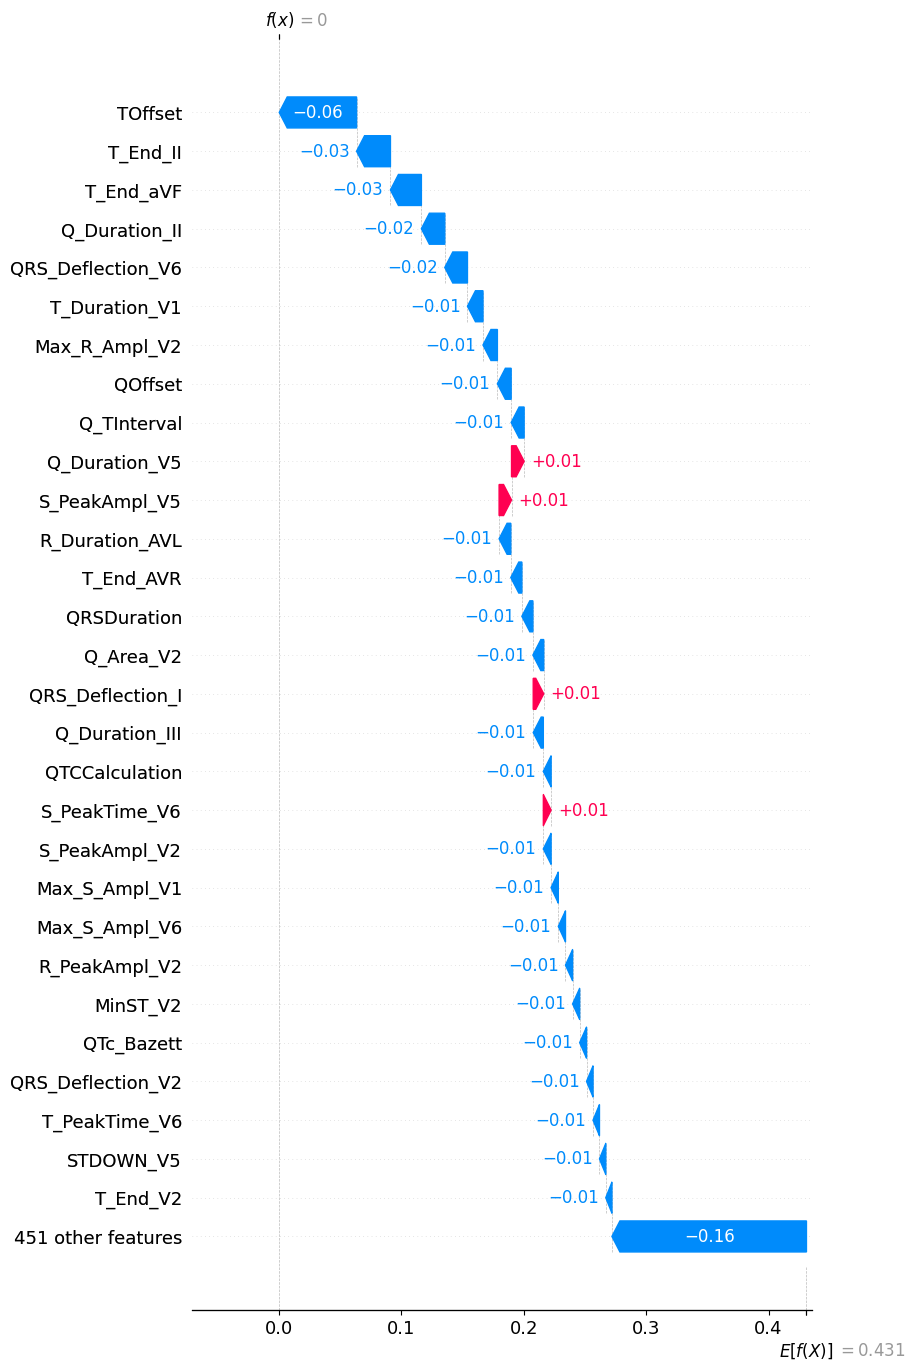

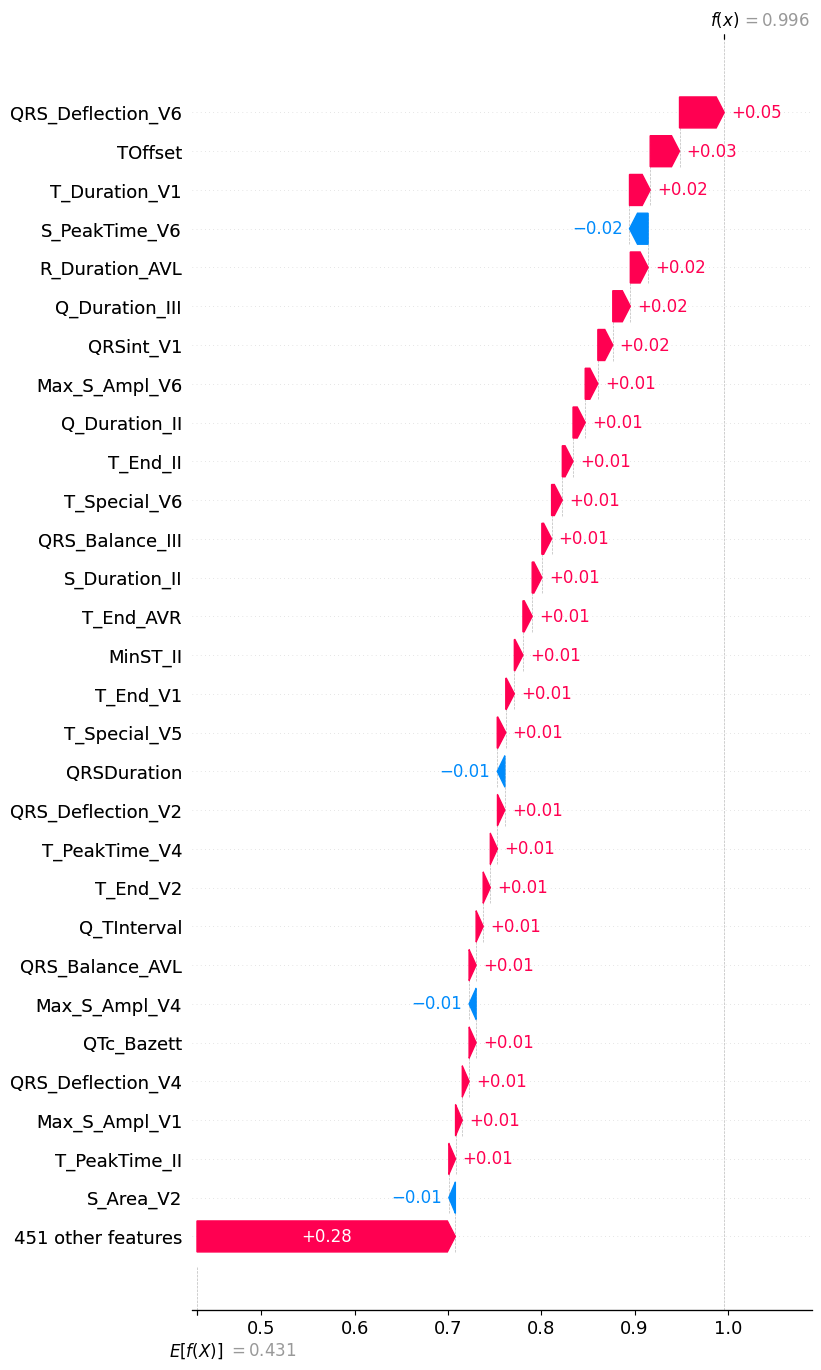

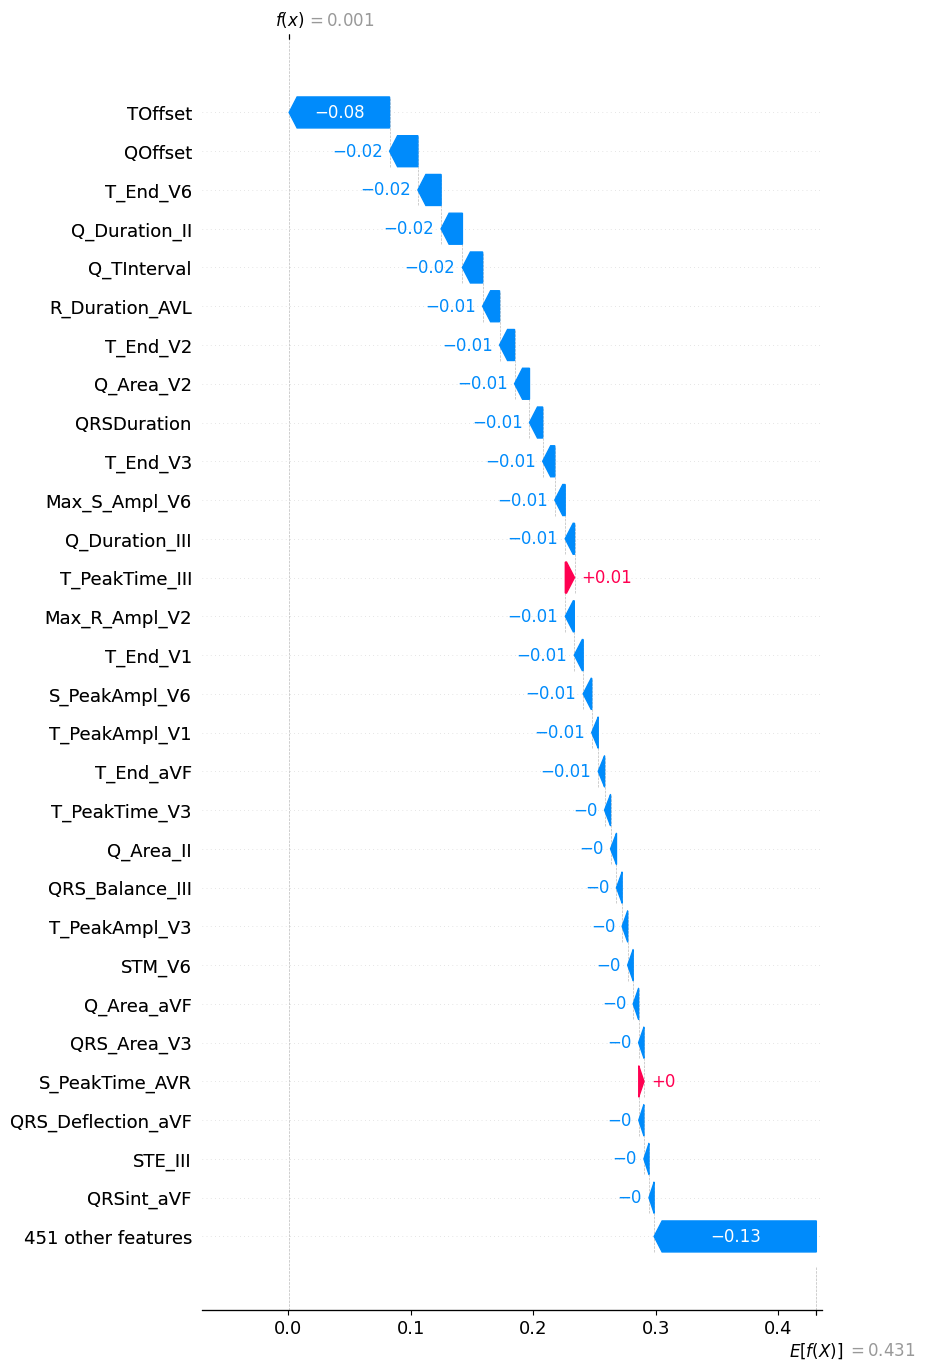

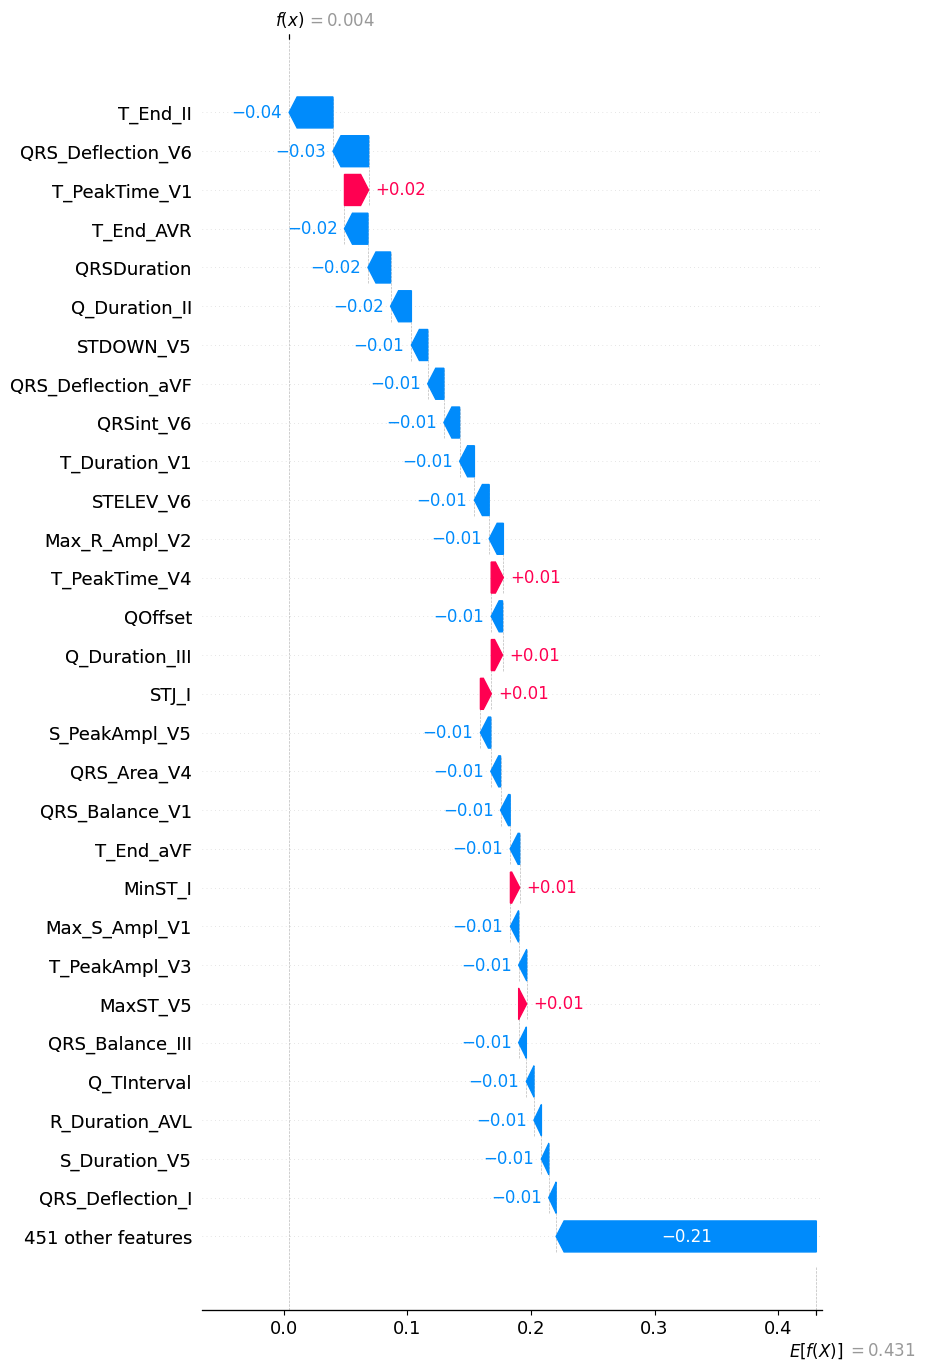

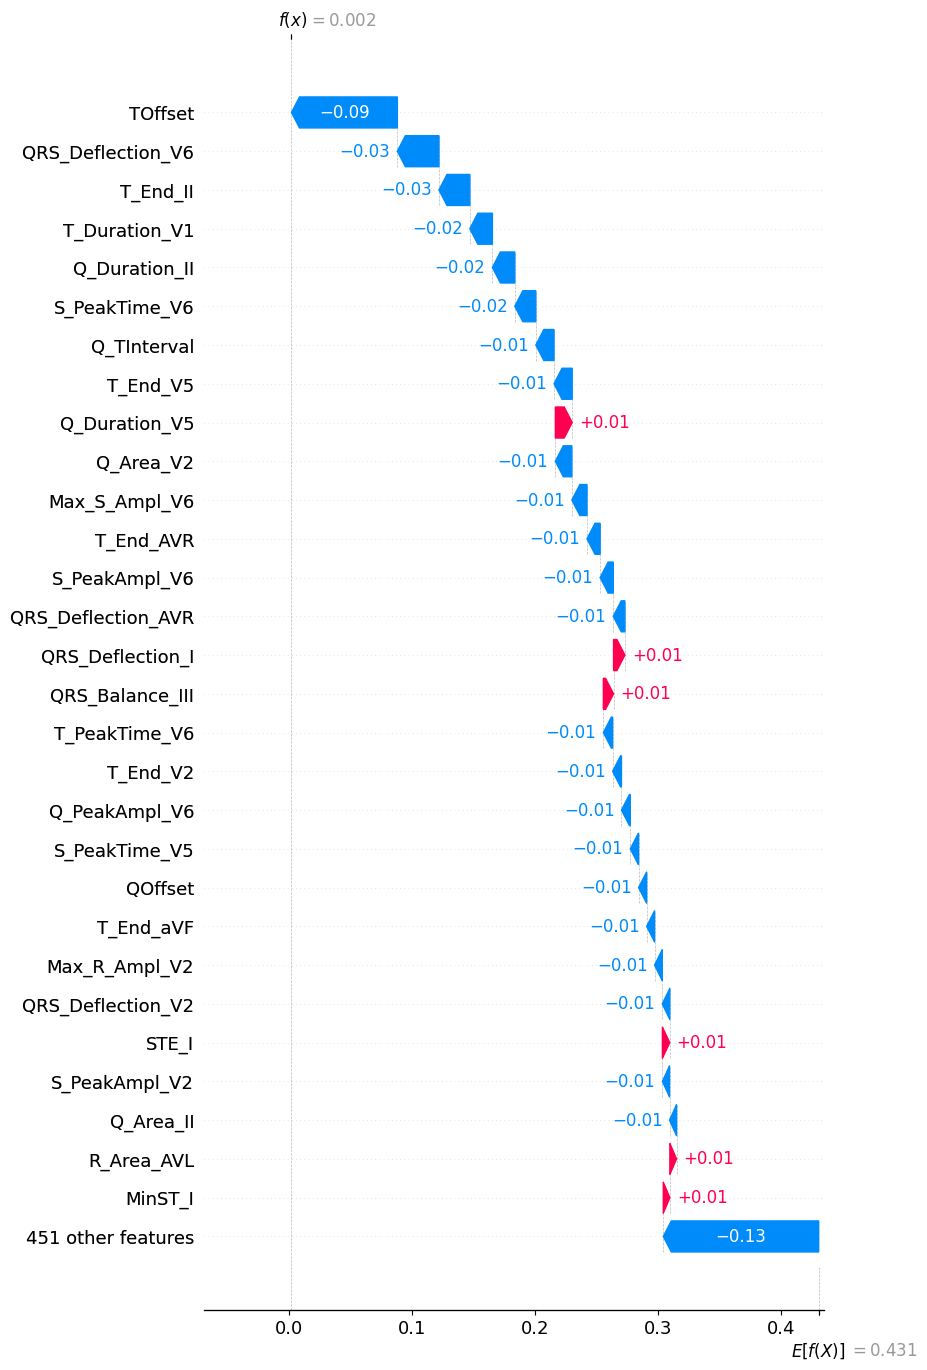

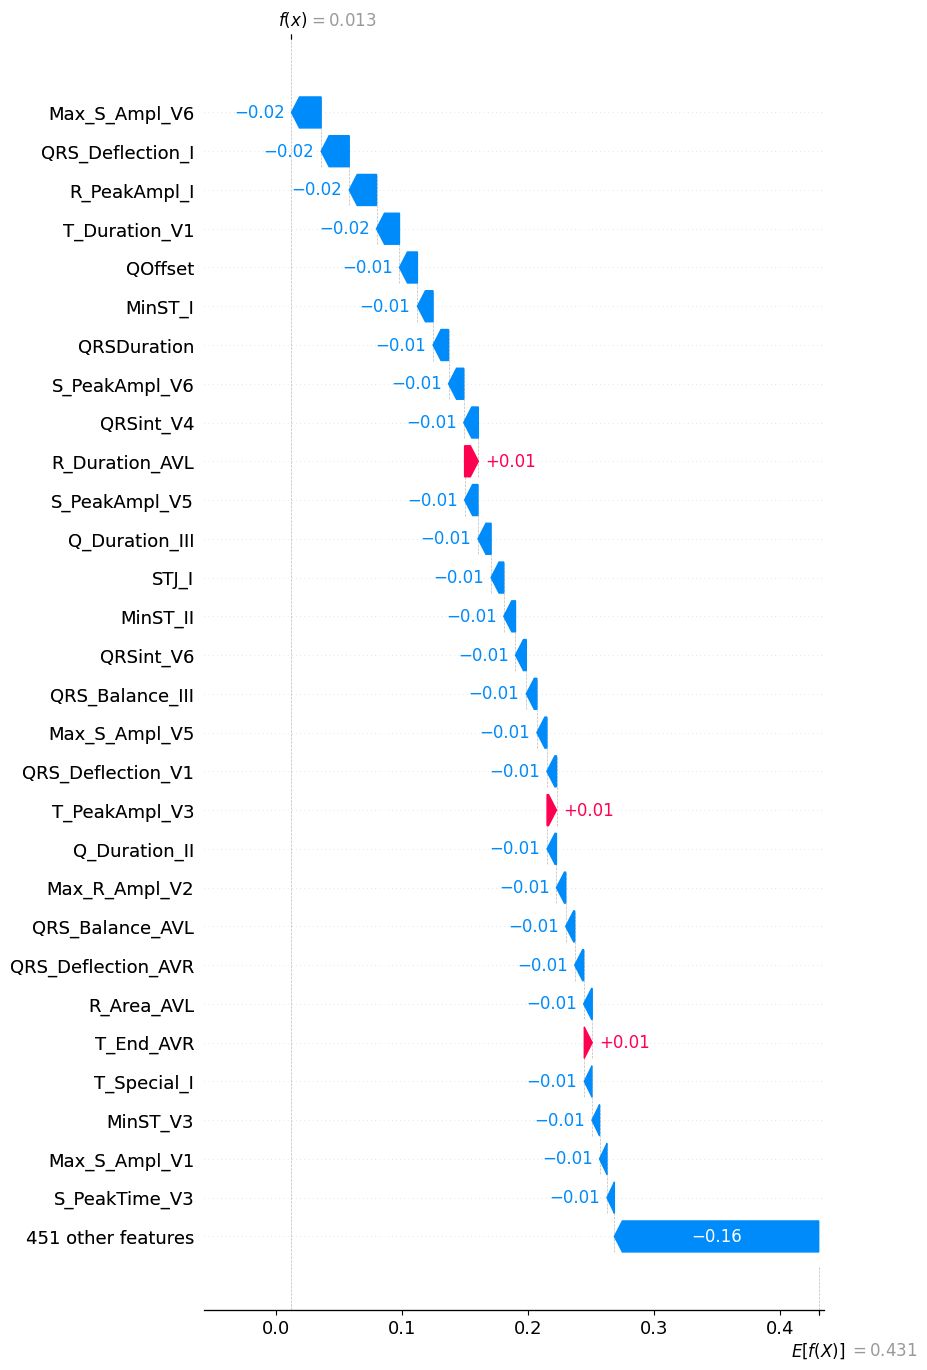

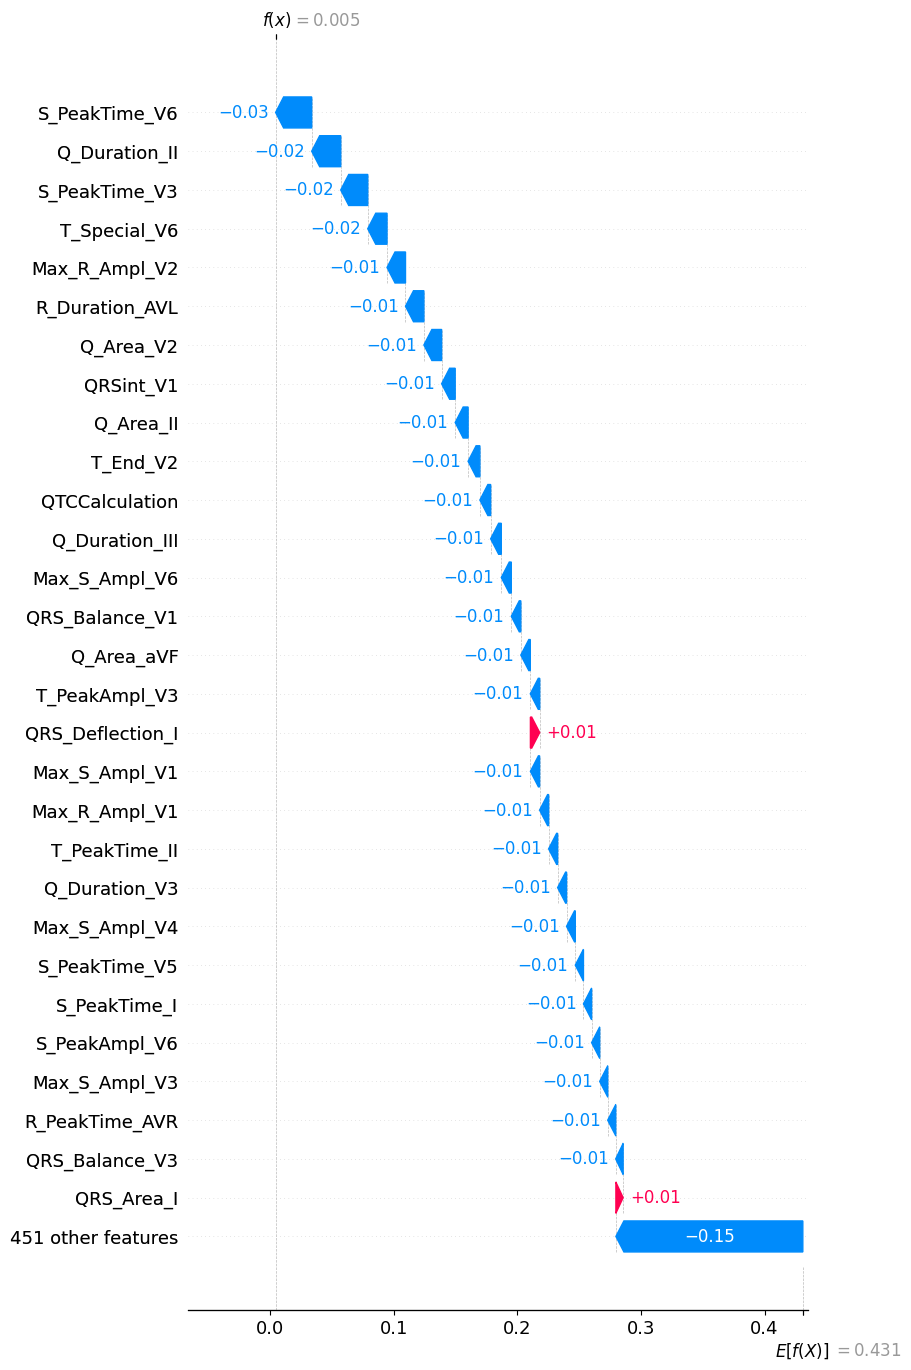

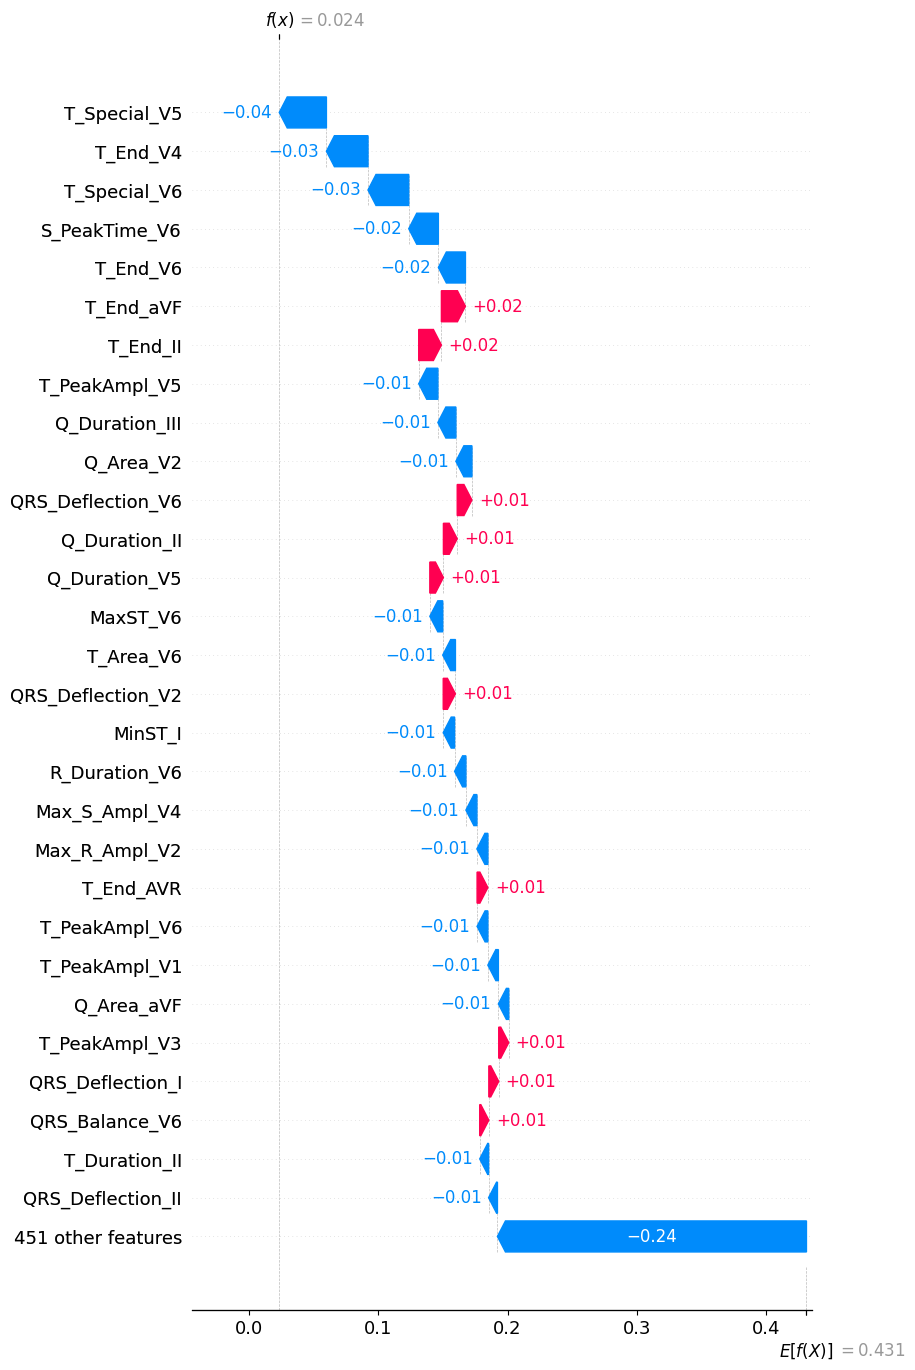

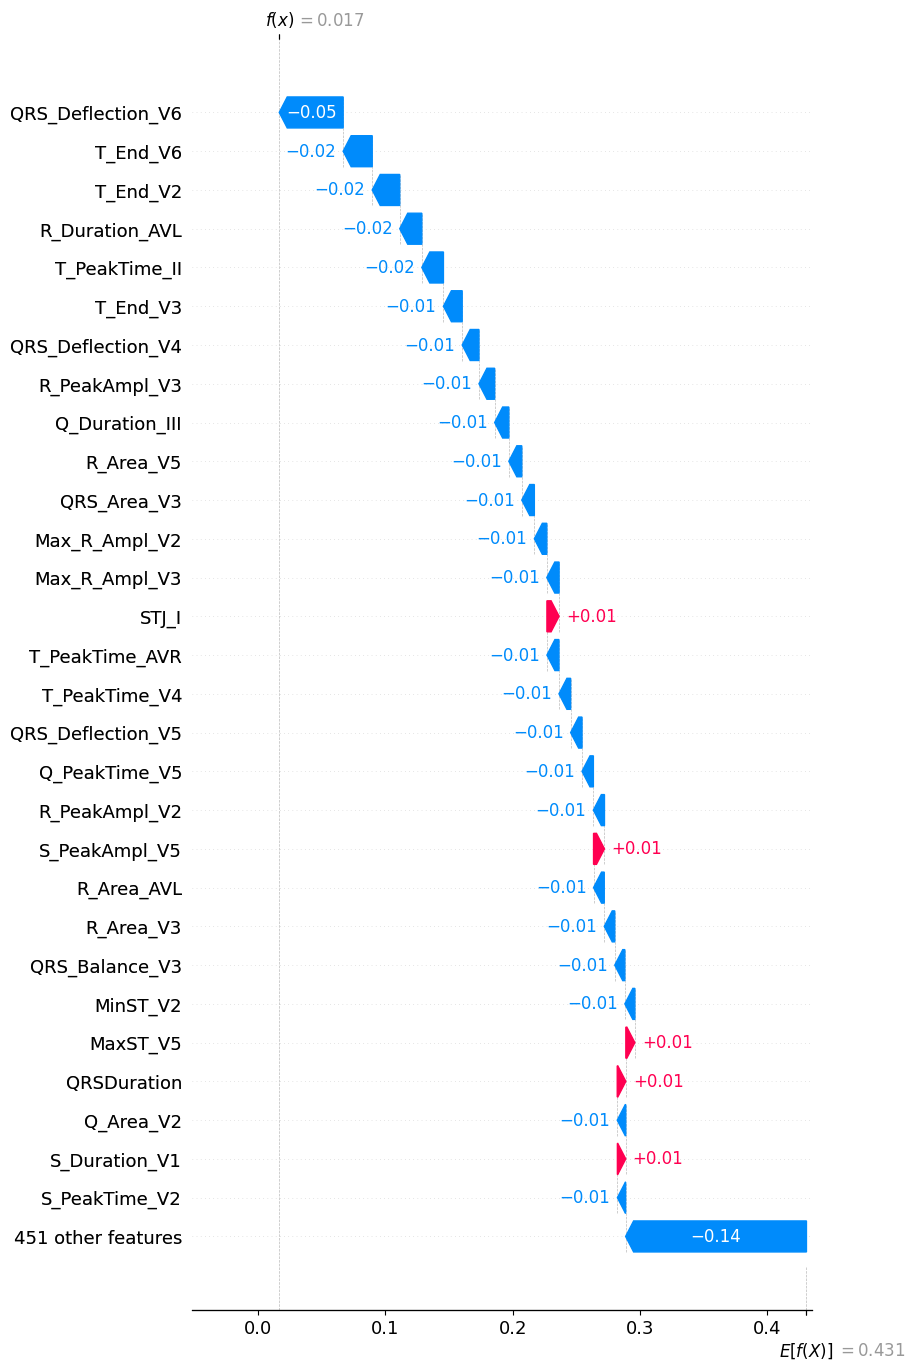

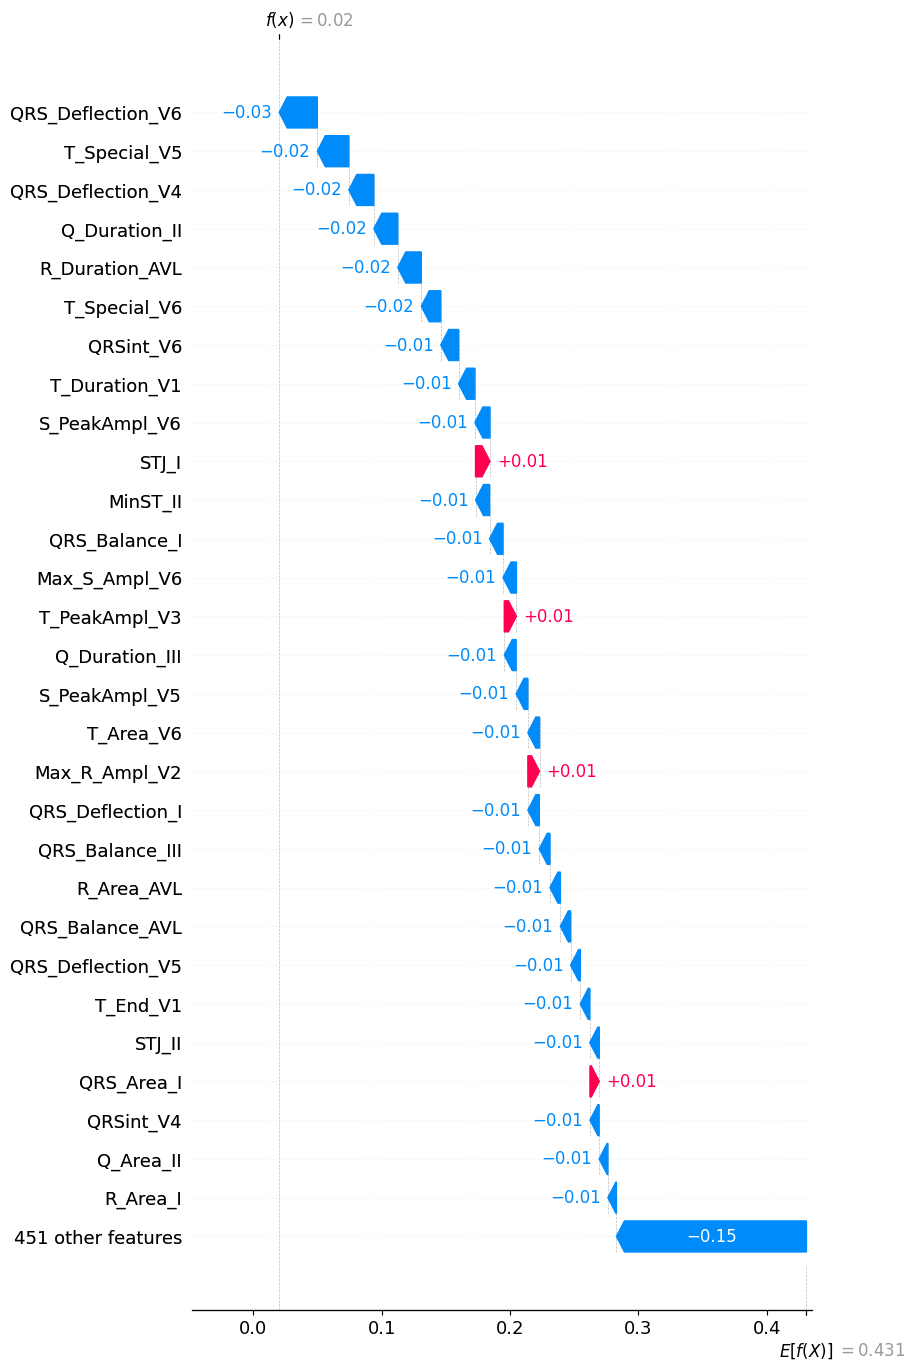

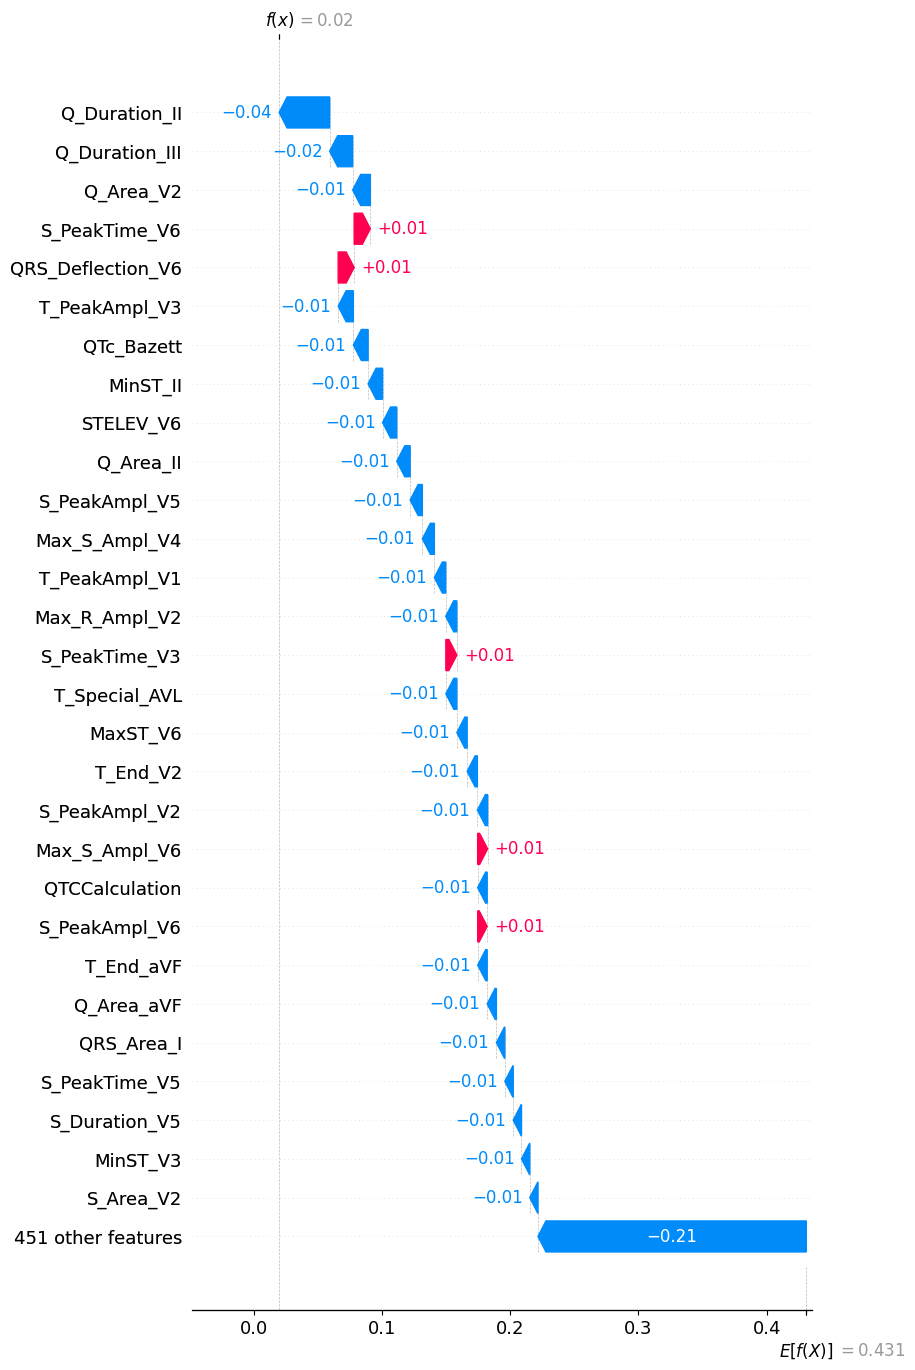

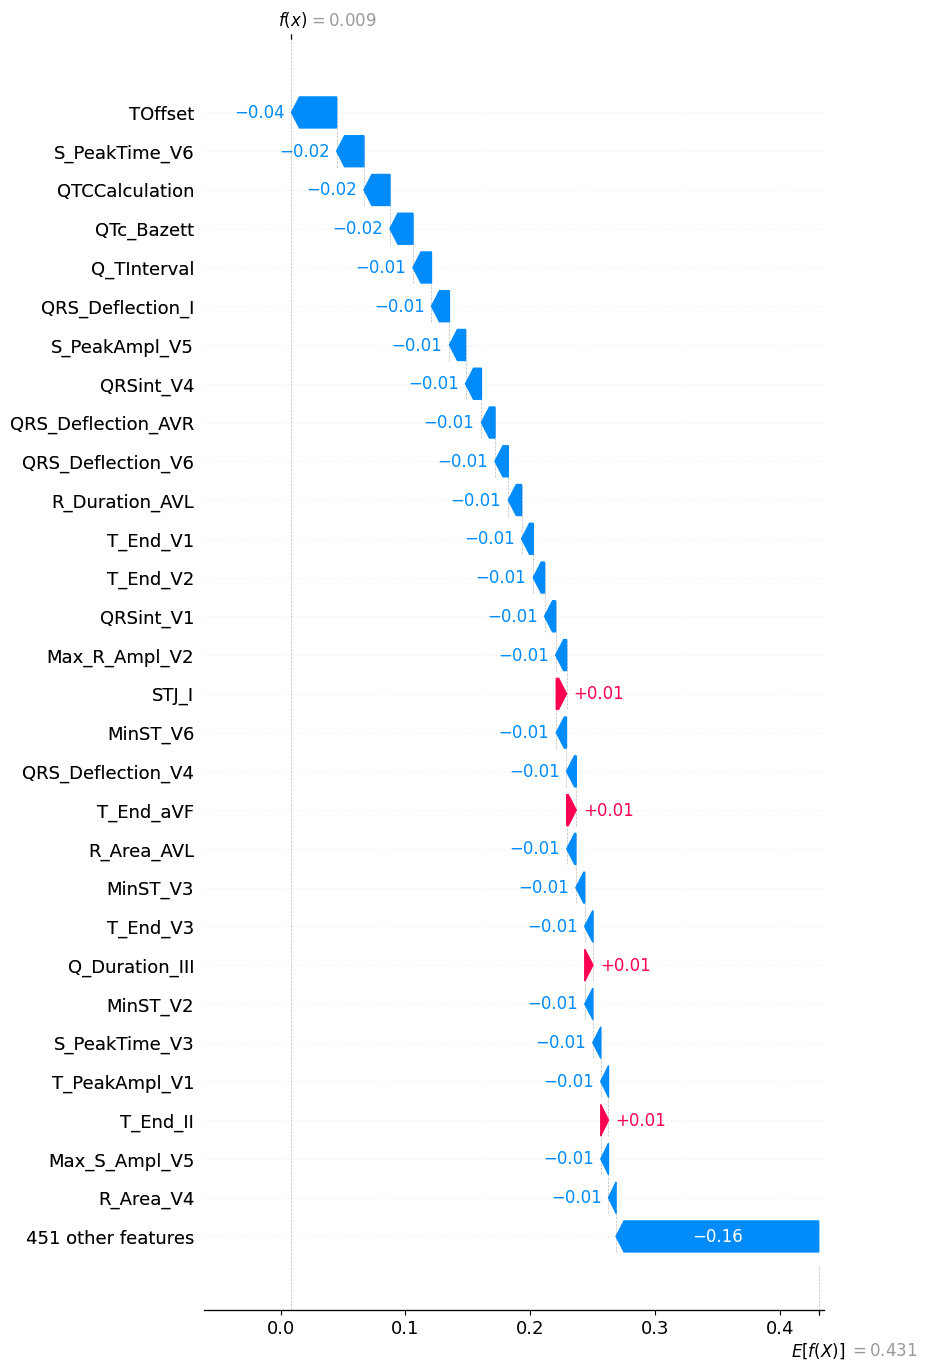

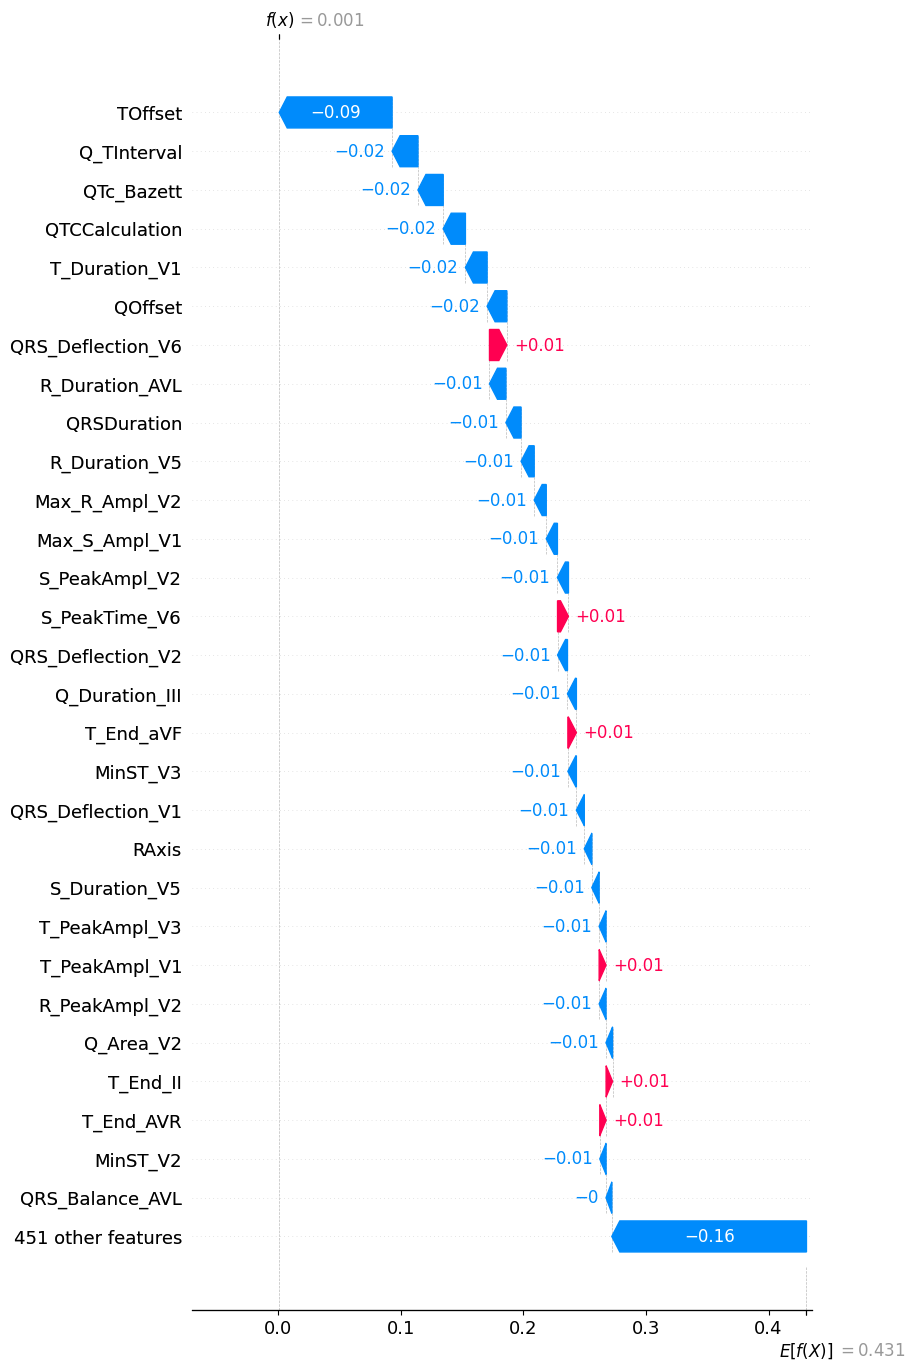

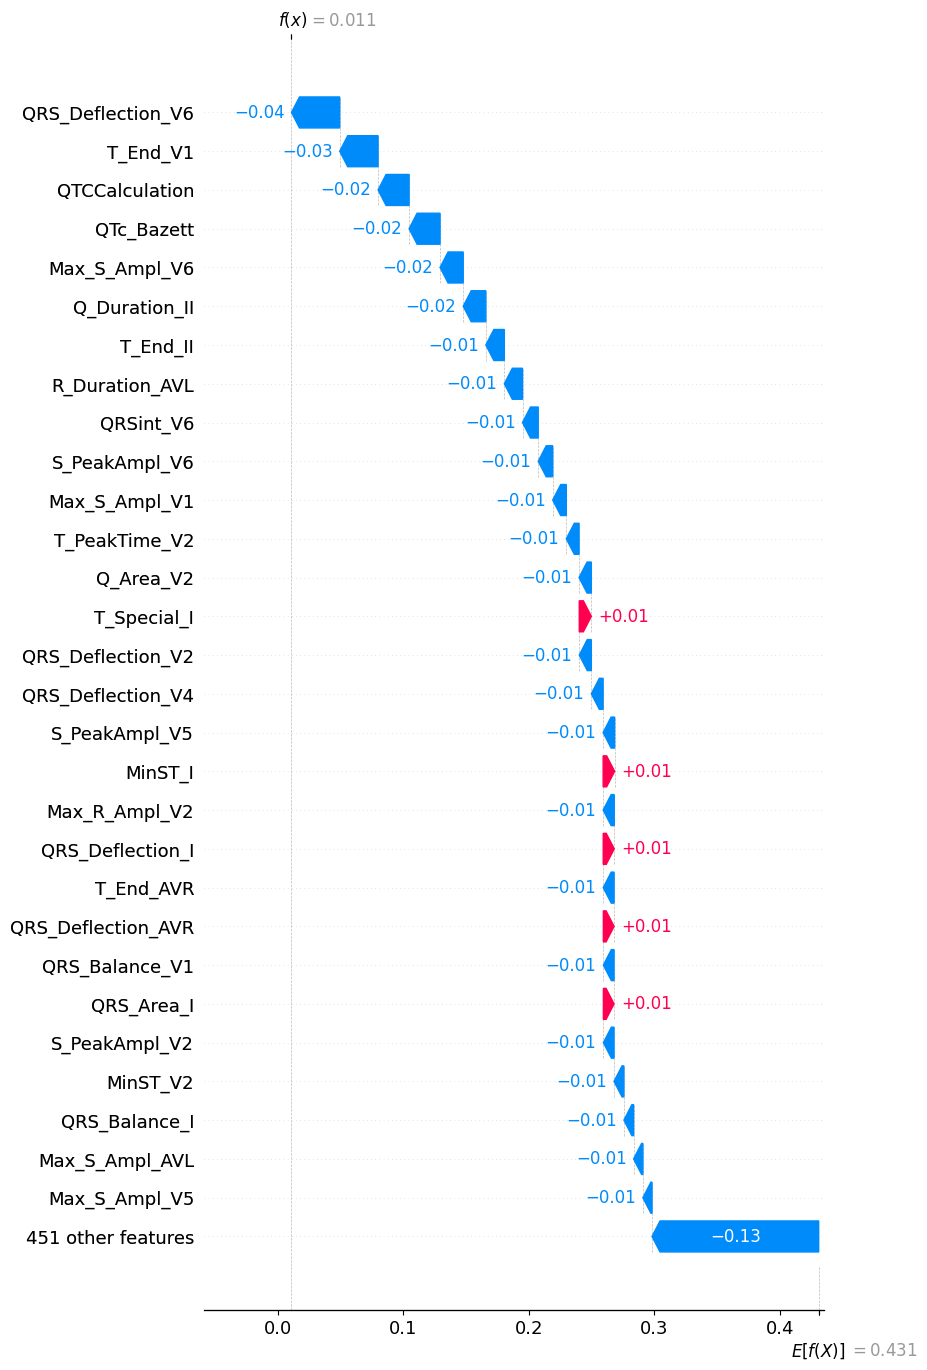

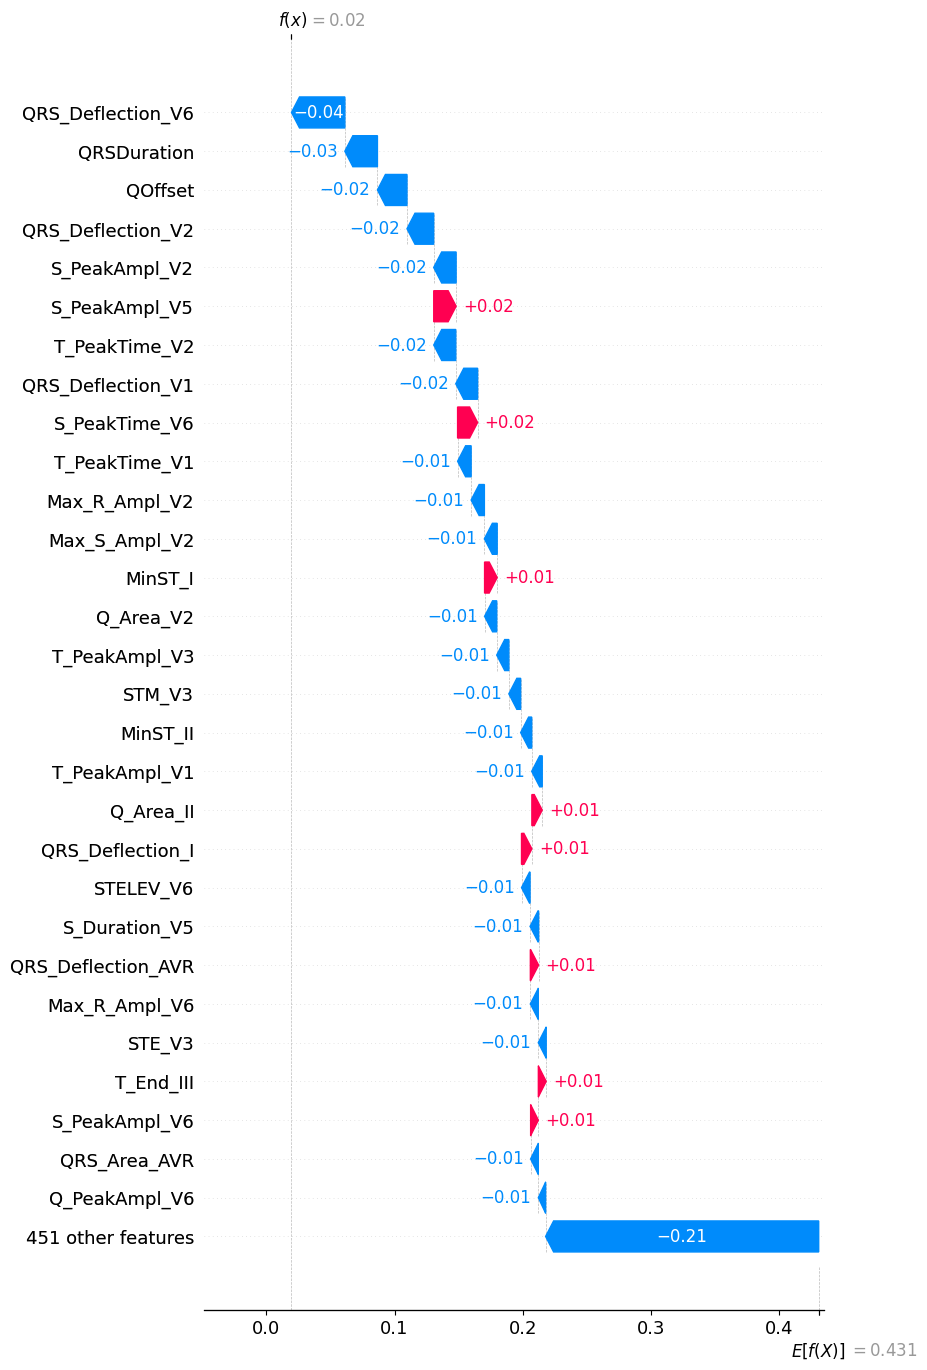

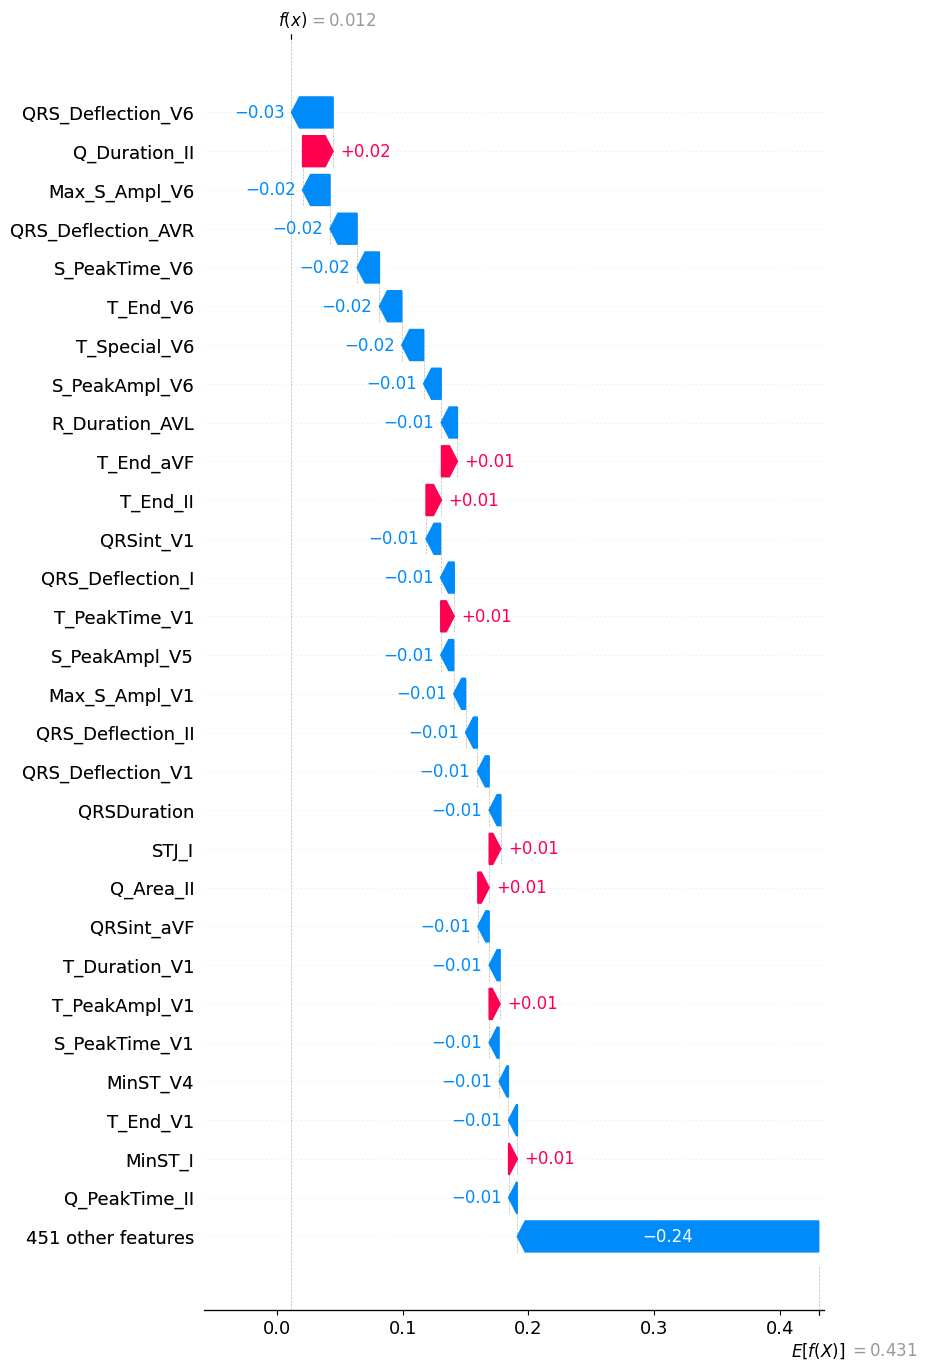

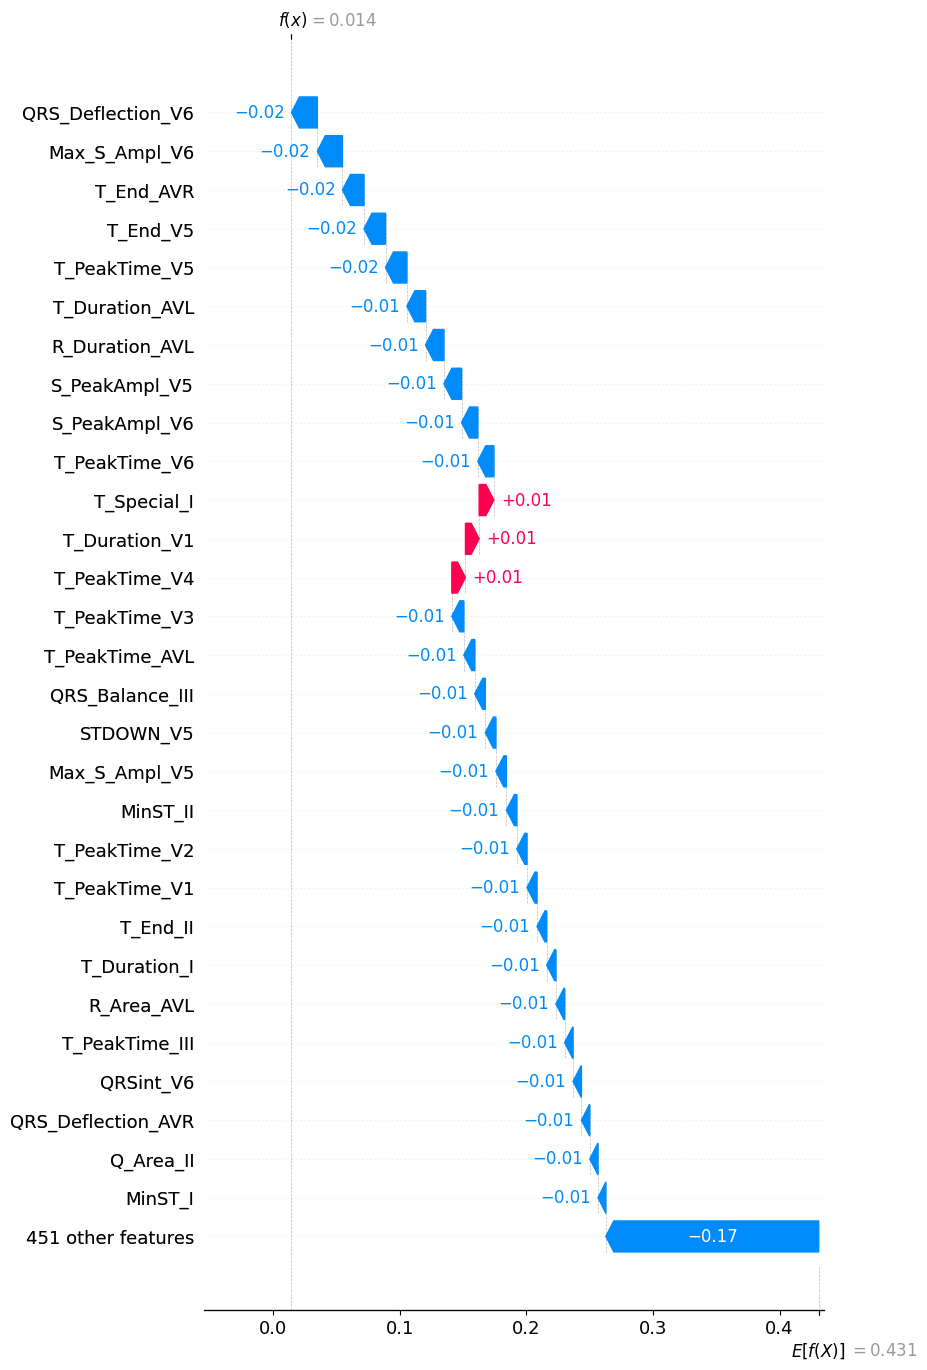

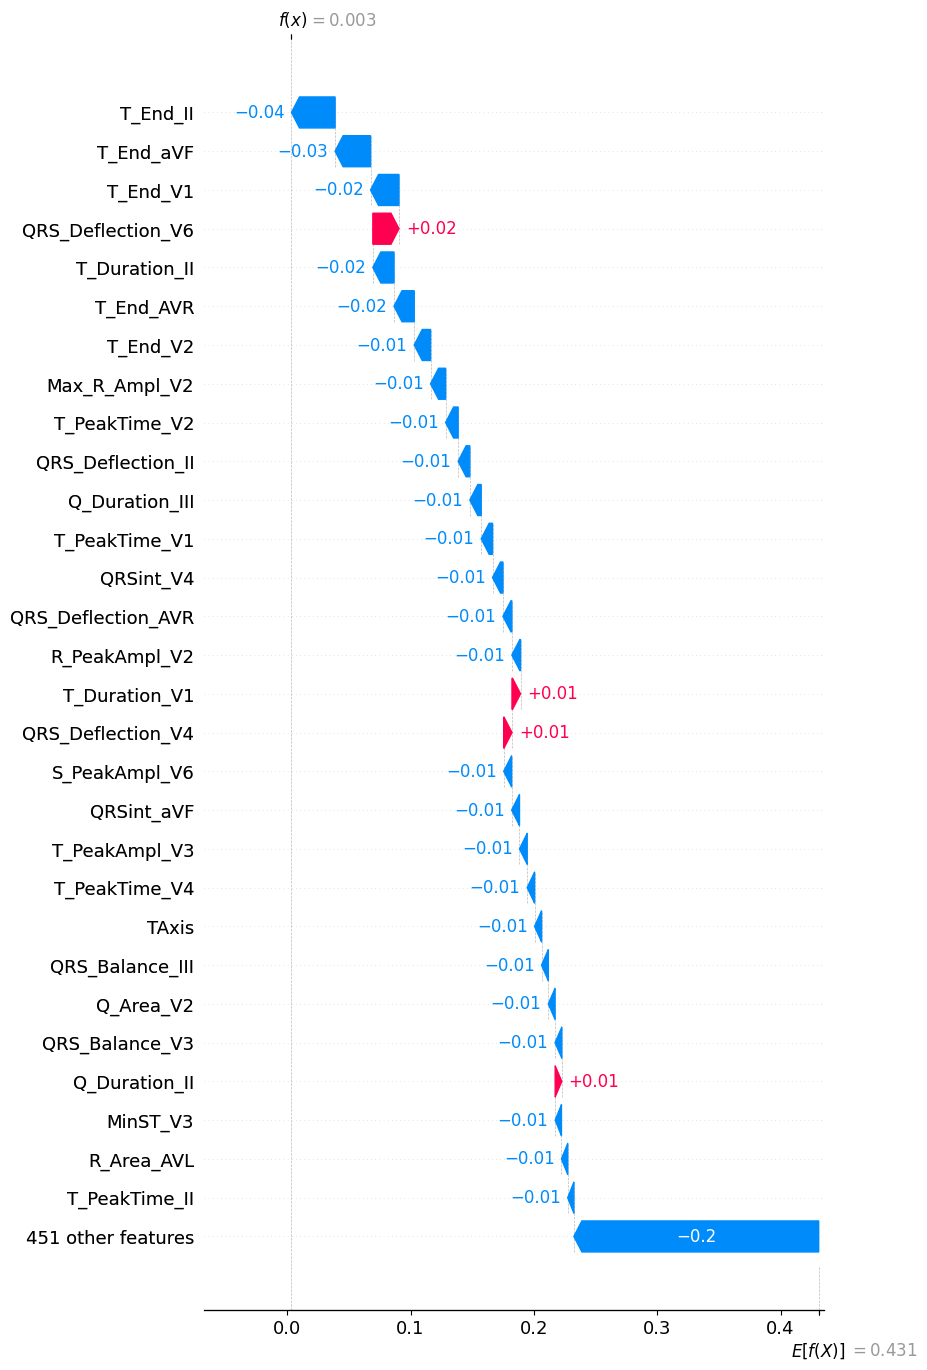

In [61]:
for i in range(len(shap_values_fp_specific)):
    shap.plots._waterfall.waterfall_legacy(
        explainer.expected_value,
        shap_values_fp_specific[i],
        feature_names=df_fp_records_clean.drop(columns=['PatientID']).columns,
        max_display=30
    )

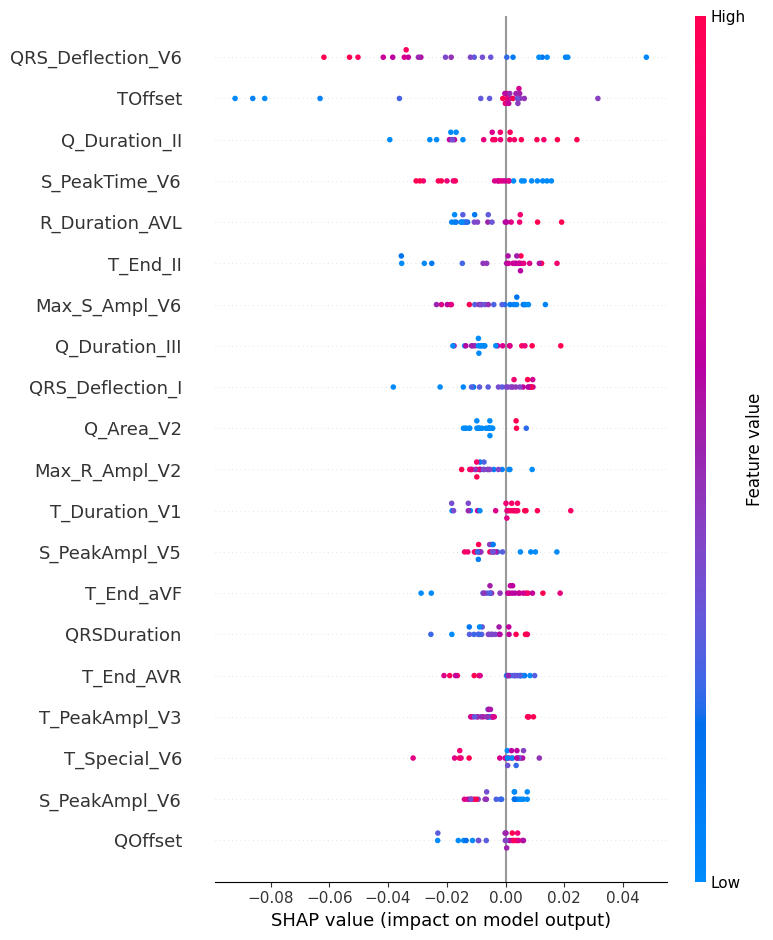

In [62]:
shap.summary_plot(shap_values_fp_specific, df_fp_records_clean.drop(columns=["PatientID"]))


In [63]:
# Predict probabilities or classes from your second model trained on 12SL positives
y_pos_pred_proba = model_pos.predict_proba(X_test_pos)[:, 1]
threshold = 0.5
y_pos_pred = (y_pos_pred_proba >= threshold).astype(int)

# Keep alignment with X_test_pos
results_pos = pd.DataFrame({
    'true': y_test_pos,
    'pred': y_pos_pred,
    'prob': y_pos_pred_proba
}, index=X_test_pos.index)


false_positives_pos = results_pos[(results_pos['pred'] == 1) & (results_pos['true'] == 0)]
false_negatives_pos = results_pos[(results_pos['pred'] == 0) & (results_pos['true'] == 1)]

X_fp_pos = X_test_pos.loc[false_positives_pos.index]
X_fn_pos = X_test_pos.loc[false_negatives_pos.index]


100%|===================| 1896/1901 [01:24<00:00]        

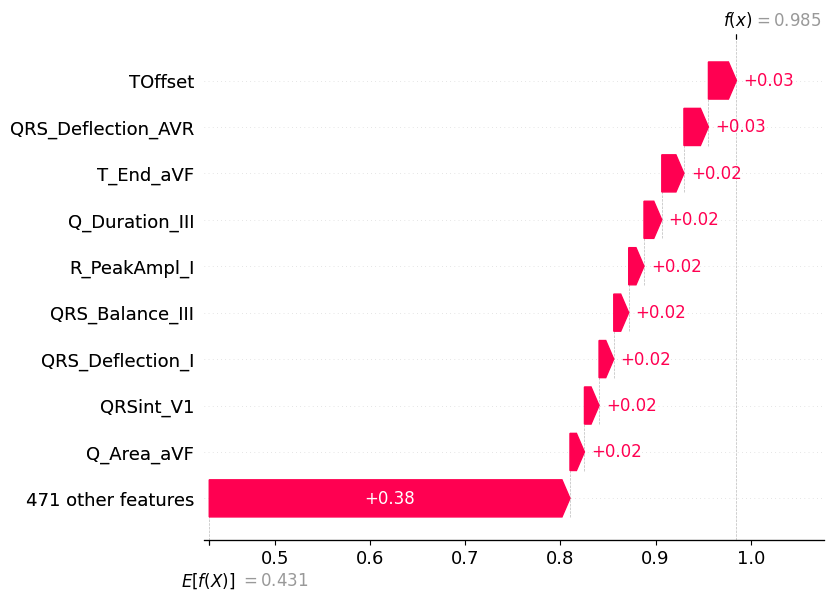

In [64]:
import shap

background = X_train_pos.sample(100, random_state=42)

# Create the explainer with reference data
explainer = shap.TreeExplainer(
    model_pos,
    data=background,
    model_output='probability',
    feature_perturbation='interventional'
)

# Now generate SHAP values without error
shap_values = explainer.shap_values(X_test_pos)

# SHAP values for FPs and FNs in the positive model
shap_values_fp = explainer.shap_values(X_fp_pos)
shap_values_fn = explainer.shap_values(X_fn_pos)

shap.initjs()
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values_fp[0], feature_names=X_fp_pos.columns)


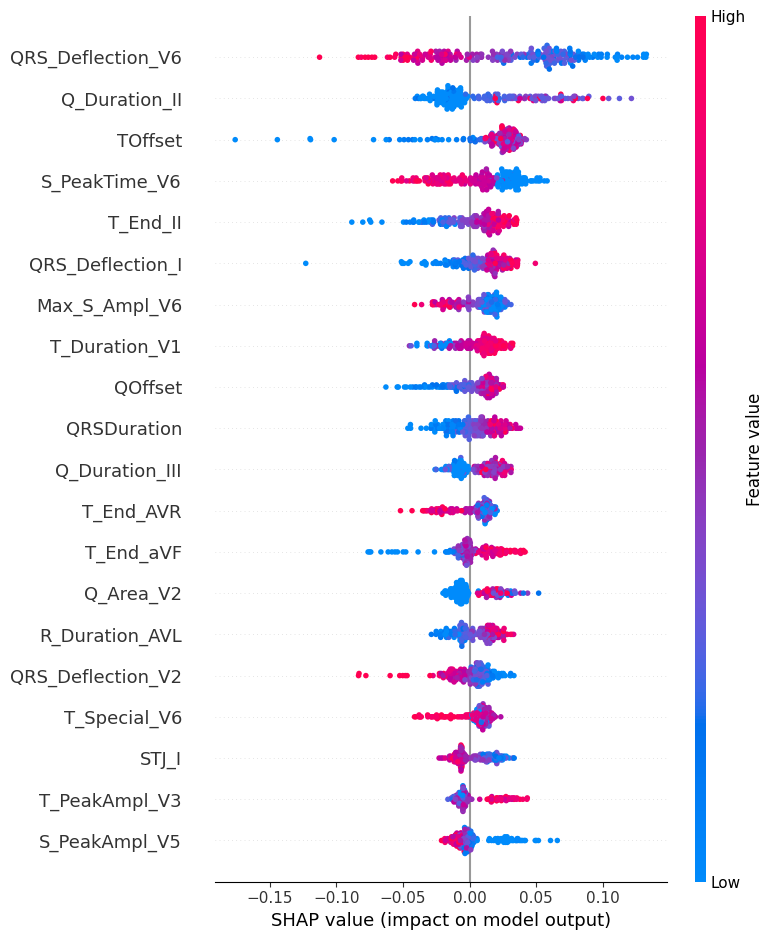

In [65]:
shap.summary_plot(shap_values_fp, X_fp_pos)

 99%|===================| 1882/1901 [01:23<00:00]        

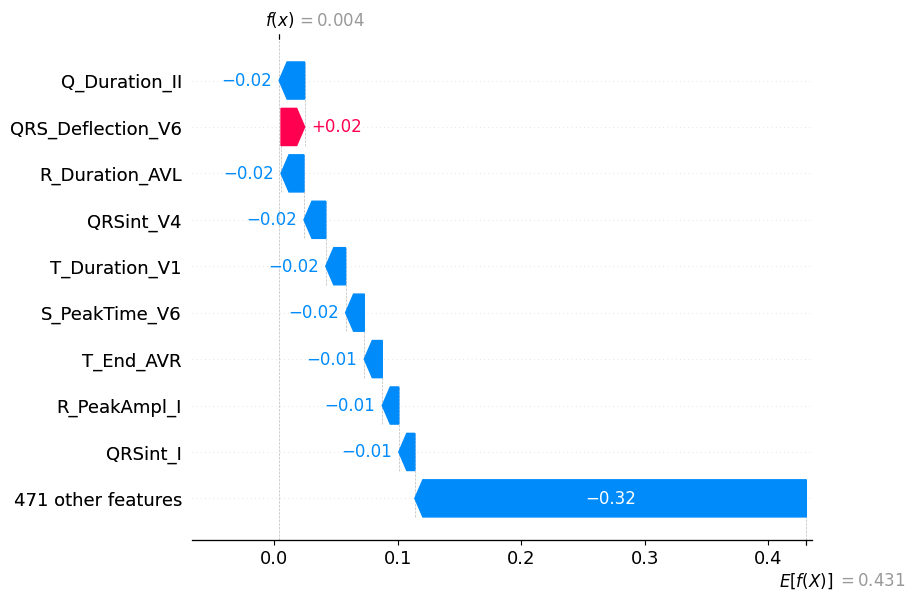

In [66]:
background = X_train_pos.sample(100, random_state=42)

# Create the explainer with reference data
explainer = shap.TreeExplainer(
    model_pos,
    data=background,
    model_output='probability',
    feature_perturbation='interventional'
)

# Now generate SHAP values without error
shap_values = explainer.shap_values(X_test_pos)

# SHAP values for FPs and FNs in the positive model
shap_values_fp = explainer.shap_values(X_fp_pos)
shap_values_fn = explainer.shap_values(X_fn_pos)

shap.initjs()
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values_fn[0], feature_names=X_fn_pos.columns)


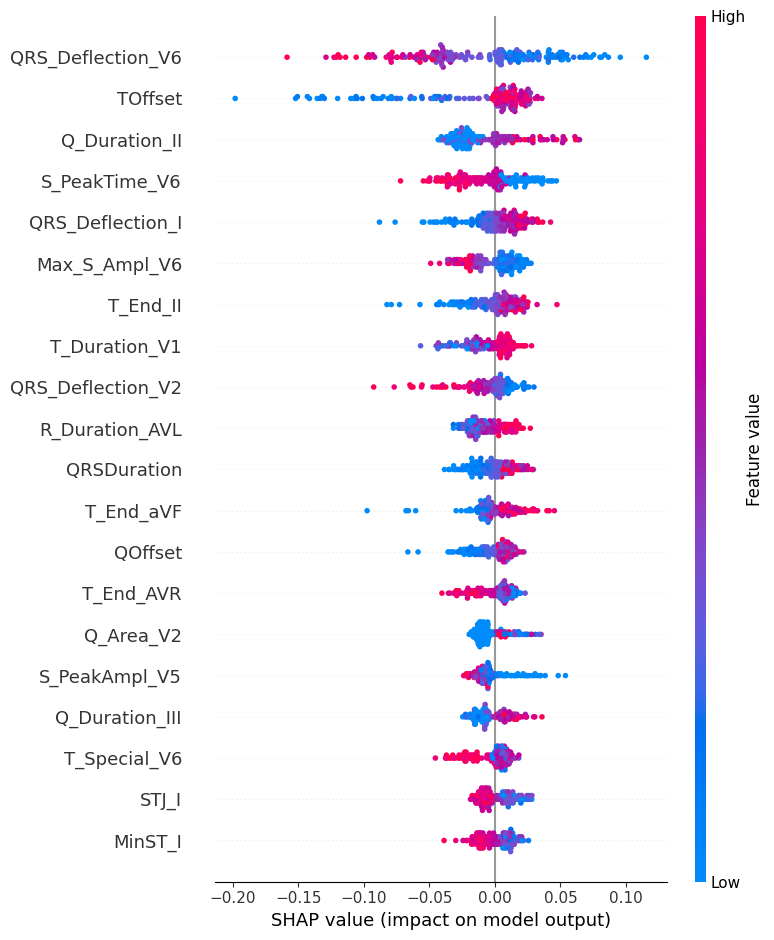

In [67]:
shap.summary_plot(shap_values_fn, X_fn_pos)

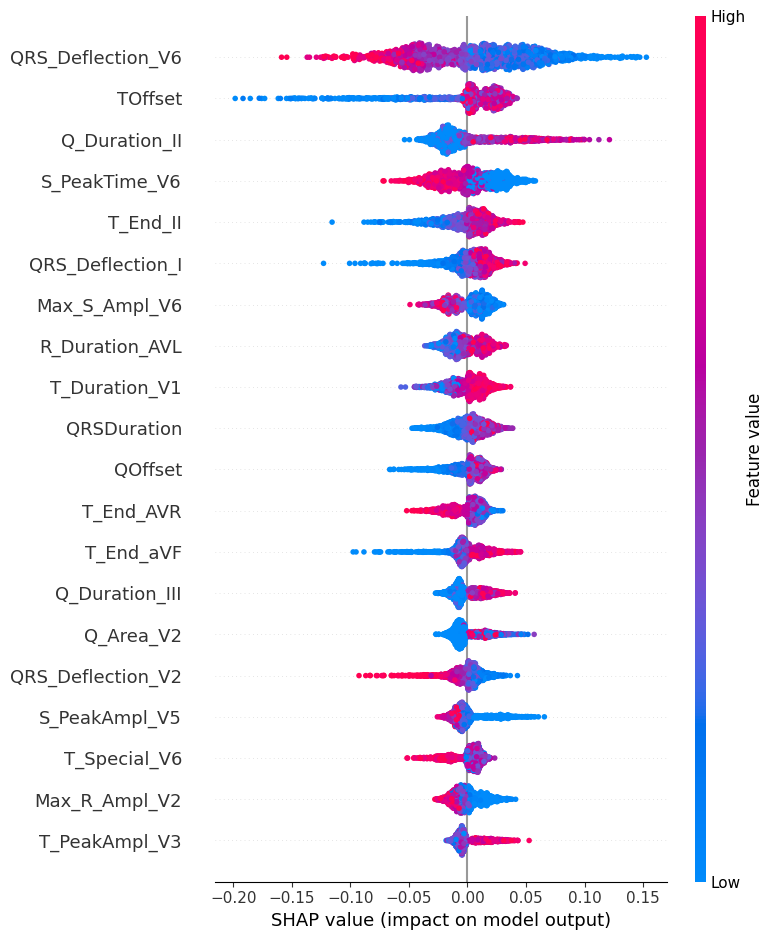

In [68]:
shap.summary_plot(shap_values, X_test_pos)

In [69]:
# import matplotlib.pyplot as plt

# feature = 'TFull_Area_6'
# plt.hist(X_test_pos[feature], bins=50, alpha=0.5, label='All 12SL Positives')
# plt.axvline(X_fp_pos[feature].mean(), color='red', label='FP Mean')
# plt.axvline(X_fn_pos[feature].mean(), color='green', label='FN Mean')
# plt.legend()
# plt.title(f'Distribution of {feature}')
# plt.show()

In [70]:
# import matplotlib.pyplot as plt

# feature = 'VentricularRate'
# plt.hist(X_test_pos[feature], bins=50, alpha=0.5, label='All 12SL Positives')
# plt.axvline(X_fp_pos[feature].mean(), color='red', label='FP Mean')
# plt.axvline(X_fn_pos[feature].mean(), color='green', label='FN Mean')
# plt.legend()
# plt.title(f'Distribution of {feature}')
# plt.show()

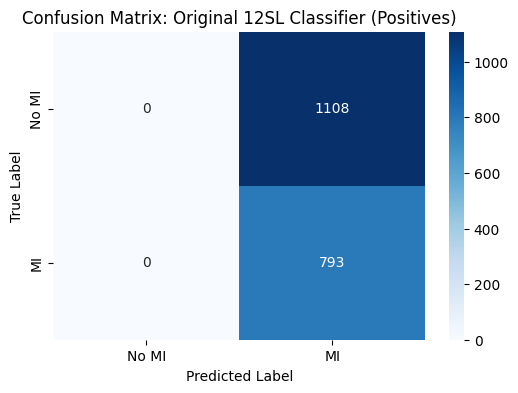

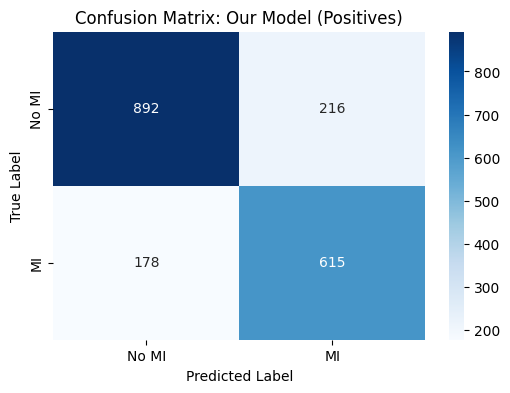

In [71]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#confusion matrix 12SL (no model)

cm = confusion_matrix(y_test_pos, y_12SL_pos)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["No MI", "MI"], yticklabels=["No MI", "MI"])
plt.title("Confusion Matrix: Original 12SL Classifier (Positives)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


#confusion matrix (from model)

cm = confusion_matrix(y_test_pos, y_pred_pos)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["No MI", "MI"], yticklabels=["No MI", "MI"])
plt.title("Confusion Matrix: Our Model (Positives)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Baseline Sensitivity (Recall): 1.0
Baseline Precision (PPV): 0.4171488690163072
Model Sensitivity (Recall): 0.7755359394703657
Model Precision (PPV): 0.740072202166065


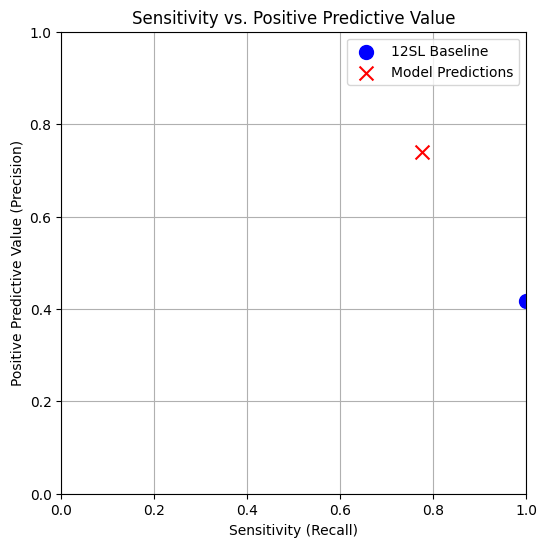

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score

y_true = y_test_pos  # Ground truth for positive subset
baseline_pred = y_12SL.loc[y_test_pos.index]  # 12SL classifier predictions for the same subset
model_pred = y_pred_pos  # Predictions from your trained model

sensitivity_baseline = recall_score(y_true, baseline_pred)
precision_baseline = precision_score(y_true, baseline_pred)

sensitivity_model = recall_score(y_true, model_pred)
precision_model = precision_score(y_true, model_pred)

print("Baseline Sensitivity (Recall):", sensitivity_baseline)
print("Baseline Precision (PPV):", precision_baseline)
print("Model Sensitivity (Recall):", sensitivity_model)
print("Model Precision (PPV):", precision_model)

plt.figure(figsize=(6,6))
plt.scatter(sensitivity_baseline, precision_baseline, 
            label='12SL Baseline', color='blue', marker='o', s=100)
plt.scatter(sensitivity_model, precision_model, 
            label='Model Predictions', color='red', marker='x', s=100)

plt.xlabel('Sensitivity (Recall)')
plt.ylabel('Positive Predictive Value (Precision)')
plt.title('Sensitivity vs. Positive Predictive Value')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


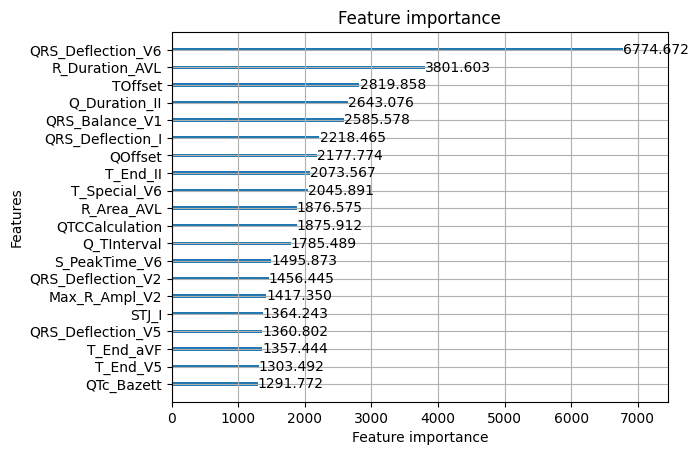

In [73]:
booster = model_pos.booster_
importances = booster.feature_importance(importance_type='split')
feature_names = booster.feature_name()

lgb.plot_importance(booster, importance_type='gain', max_num_features=20)
plt.show()


Number of components selected: 277
Total variance explained: 0.9501401527639174
Principal components shape: (61047, 277)


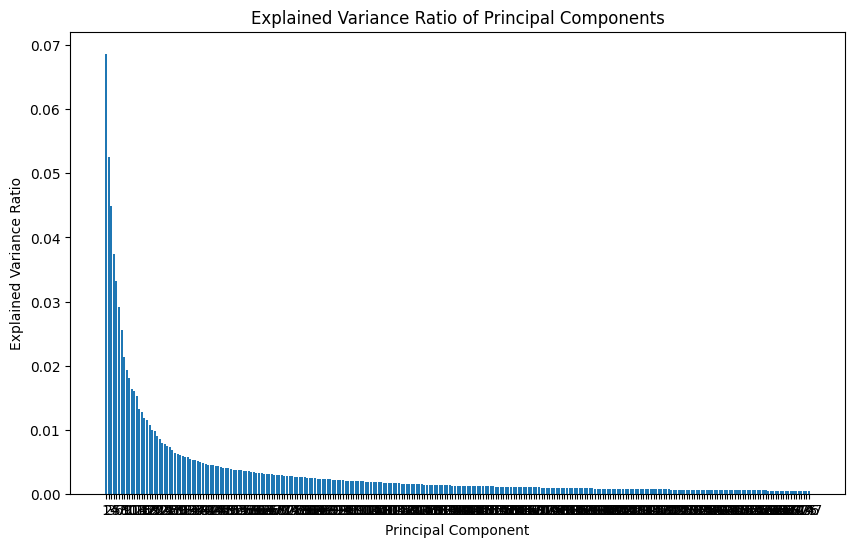

In [74]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_cols = df.drop(columns=['PatientID', '12SL_Codes', 'Phys_Codes','TestID', 'Source', 'MI_12SL', 'Gender', 'PatientAge', 'AcquisitionDateTime_DT', 'MI_Phys'])
# drop NaN values
df_cols = df_cols.dropna()
X_scaled = scaler.fit_transform(df_cols)

pca = PCA(n_components=0.95, random_state=42)  # keep 95% of variance
principal_components = pca.fit_transform(X_scaled)

print("Number of components selected:", pca.n_components_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())
print("Principal components shape:", principal_components.shape)
#column names from original data
feature_names = df_cols.columns

# Create a DataFrame with the principal components
df_pca = pd.DataFrame(data=principal_components, columns=[f"PC{i}" for i in range(1, pca.n_components_ + 1)])

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_)
plt.title("Explained Variance Ratio of Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xticks(range(1, pca.n_components_ + 1))
plt.show()

In [75]:
# Negative Model

In [76]:
lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'n_estimators': 200,
    'learning_rate': 0.1,
    'random_state': 42,
    'verbose': -1,
    'num_leaves': 127,
    'scale_pos_weight': 10,
    'device': 'gpu',
    }
model_neg = (lgb.LGBMClassifier(**lgb_params))
model_neg.fit(X_train_neg, y_train_neg)
y_pred_neg = model_neg.predict(X_test_neg)
score = f1_score(y_test_neg, y_pred_neg, average='micro')
print("Final F1 score: ", score)

Final F1 score:  0.9543611295436113


In [77]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

X = X_train_neg
y = y_train_neg

# Hyperparameter search space
space = {
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 10),
}

def objective(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['device'] = 'gpu'
    
    clf = lgb.LGBMClassifier(
        n_estimators=500,
        objective='binary',
        # metric='auc',
        verbose=-1,
        **params
    )
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(clf, X, y, scoring='f1', cv=cv).mean()
    
    return {'loss': 1 - score, 'status': STATUS_OK}

trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,  
    trials=trials,
    rstate=np.random.Generator(np.random.PCG64(42))
)

print("Best hyperparameters:", best)


100%|██████████| 50/50 [29:26<00:00, 35.33s/trial, best loss: 0.4896222081962167] 
Best hyperparameters: {'boosting_type': np.int64(1), 'colsample_bytree': np.float64(0.7088568942556404), 'learning_rate': np.float64(0.07765756879588495), 'max_depth': np.float64(7.0), 'min_child_weight': np.float64(9.0), 'num_leaves': np.float64(127.0), 'reg_alpha': np.float64(0.12279129887526408), 'reg_lambda': np.float64(0.4153931600716712), 'scale_pos_weight': np.float64(6.281928161983453), 'subsample': np.float64(0.7015803362702964)}


In [78]:
#run model with the parameters from the dictionary with the model parameters from "best"
boosting_type = ['gbdt', 'dart']
best['boosting_type'] = boosting_type[best['boosting_type']]
lgb_params = {
    'objective': 'binary',
    'boosting_type': best['boosting_type'],
    'colsample_bytree': best['colsample_bytree'],
    'n_estimators': 1000,
    'learning_rate': best['learning_rate'],
    'random_state': 42,
    'verbose': -1,
    'num_leaves': int(best['num_leaves']),
    'min_child_weight': int(best['min_child_weight']),
    'max_depth' : int(best['max_depth']),
    'reg_alpha' : best['reg_alpha'],
    'reg_lambda' : best['reg_lambda'],
    'subsample' : best['subsample'],
    # 'metric': 'auc', 
    'scale_pos_weight': best['scale_pos_weight'],
    'device': 'gpu',
    }

model_neg = (lgb.LGBMClassifier(**lgb_params))
model_neg.fit(X_train_neg, y_train_neg)
y_pred_neg = model_neg.predict(X_test_neg)
score = f1_score(y_test_neg, y_pred_neg, average='micro')
print("Final F1 score: ", score)

Final F1 score:  0.9520017695200177


In [79]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np

X = X_train_neg
y = y_train_neg

def objective(trial):
    # Define the search space
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart'])
    num_leaves = trial.suggest_int('num_leaves', 20, 150)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.2, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1.0)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1.0)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    scale_pos_weight = trial.suggest_float('scale_pos_weight', 1.0, 10.0)

    # Construct classifier
    clf = lgb.LGBMClassifier(
        n_estimators=1000,
        objective='binary',
        boosting_type=boosting_type,
        num_leaves=num_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        min_child_weight=min_child_weight,
        scale_pos_weight=scale_pos_weight,
        verbose=-1,
        device='gpu',
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = cross_val_score(clf, X, y, scoring='f1', cv=cv)
    mean_f1 = np.mean(f1_scores)

    return 1 - mean_f1  # Optuna minimizes the objective

# Create and run the Optuna study
study = optuna.create_study(direction='minimize') 
study.optimize(objective, n_trials=50, n_jobs=-1)

print("Best trial:")
print(study.best_trial)
print("Best F1 Score:", 1 - study.best_value)
print("Best hyperparameters:", study.best_params)


[I 2025-04-11 17:19:12,681] A new study created in memory with name: no-name-957d69fb-80a2-44f3-9286-7059279ad029
[I 2025-04-11 17:21:59,999] Trial 27 finished with value: 0.5544445964567416 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 108, 'max_depth': 3, 'learning_rate': 0.008345408269937425, 'subsample': 0.9914033300088102, 'colsample_bytree': 0.6573982133748032, 'reg_alpha': 0.6033055158747987, 'reg_lambda': 0.09666463146640458, 'min_child_weight': 1, 'scale_pos_weight': 6.912338502116426}. Best is trial 27 with value: 0.5544445964567416.
[I 2025-04-11 17:23:54,644] Trial 15 finished with value: 0.4905493434061572 and parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'max_depth': 3, 'learning_rate': 0.16801175782487923, 'subsample': 0.7916467556305383, 'colsample_bytree': 0.681000600264972, 'reg_alpha': 0.4810585743607495, 'reg_lambda': 0.7499497706061888, 'min_child_weight': 10, 'scale_pos_weight': 4.069536775591179}. Best is trial 15 with value: 0.49054934340615

Best trial:
FrozenTrial(number=41, state=1, values=[0.48621982219462834], datetime_start=datetime.datetime(2025, 4, 11, 17, 39, 43, 943323), datetime_complete=datetime.datetime(2025, 4, 11, 17, 57, 49, 510590), params={'boosting_type': 'gbdt', 'num_leaves': 52, 'max_depth': 9, 'learning_rate': 0.01263147328055728, 'subsample': 0.7002106711438181, 'colsample_bytree': 0.6050098509742264, 'reg_alpha': 0.3216470241090927, 'reg_lambda': 0.6751563559790364, 'min_child_weight': 8, 'scale_pos_weight': 8.481322670135935}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'boosting_type': CategoricalDistribution(choices=('gbdt', 'dart')), 'num_leaves': IntDistribution(high=150, log=False, low=20, step=1), 'max_depth': IntDistribution(high=15, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=True, low=0.005, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False,

In [80]:
#run model with optuna best params
lgb_params = {
    'objective': 'binary',
    'boosting_type': study.best_params['boosting_type'],
    'colsample_bytree': study.best_params['colsample_bytree'],
    'n_estimators': 1000,
    'learning_rate': study.best_params['learning_rate'],
    'random_state': 42,
    'verbose': -1,
    'num_leaves': int(study.best_params['num_leaves']),
    'min_child_weight': int(study.best_params['min_child_weight']),
    'max_depth' : int(study.best_params['max_depth']),
    'reg_alpha' : study.best_params['reg_alpha'],
    'reg_lambda' : study.best_params['reg_lambda'],
    'subsample' : study.best_params['subsample'],
    # 'metric': 'auc', 
    'scale_pos_weight': study.best_params['scale_pos_weight'],
    'device': 'gpu',
}

model_neg = (lgb.LGBMClassifier(**lgb_params))
model_neg.fit(X_train_neg, y_train_neg)
y_pred_neg = model_neg.predict(X_test_neg)
score = f1_score(y_test_neg, y_pred_neg, average='micro')
print("Final F1 score: ", score)

Final F1 score:  0.939541399395414


In [81]:

# Predict probabilities or classes from your second model trained on 12SL positives
y_pos_pred_proba = model_neg.predict_proba(X_test_neg)[:, 1]
threshold = 0.5
y_pos_pred = (y_pos_pred_proba >= threshold).astype(int)

# Keep alignment with X_test_pos
results_neg = pd.DataFrame({
    'true': y_test_neg,
    'pred': y_pos_pred,
    'prob': y_pos_pred_proba
}, index=X_test_neg.index)


false_positives_neg = results_neg[(results_neg['pred'] == 1) & (results_neg['true'] == 0)]
false_negatives_neg = results_neg[(results_neg['pred'] == 0) & (results_neg['true'] == 1)]

X_fp_neg = X_test_neg.loc[false_positives_neg.index]
X_fn_neg = X_test_neg.loc[false_negatives_neg.index]


In [82]:
import shap

# Use the same background sample from your training set
background = X_train_neg.sample(100, random_state=42)

explainer = shap.TreeExplainer(
    model_neg,
    data=background,
    model_output='probability',
    feature_perturbation='interventional'
)

# Generate SHAP values for your specific records
shap_values_fn_specific = explainer.shap_values(df_fn_records_clean.drop(columns=["PatientID"]))
# shap_values_fp_specific = explainer.shap_values(df_fp_records_clean.drop(columns=["PatientID"]))


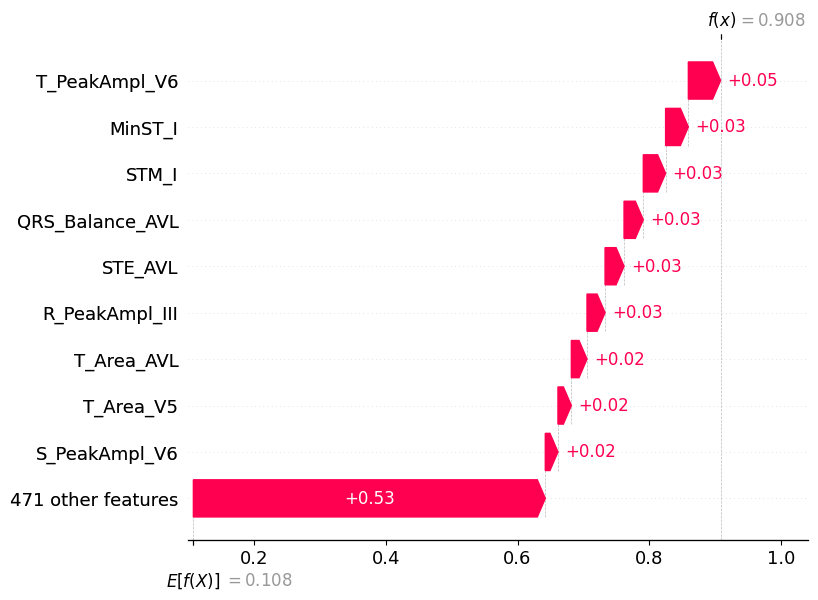

In [83]:
shap.initjs()
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values_fn_specific[0],
    feature_names=df_fn_records_clean.drop(columns = ['PatientID']).columns
)


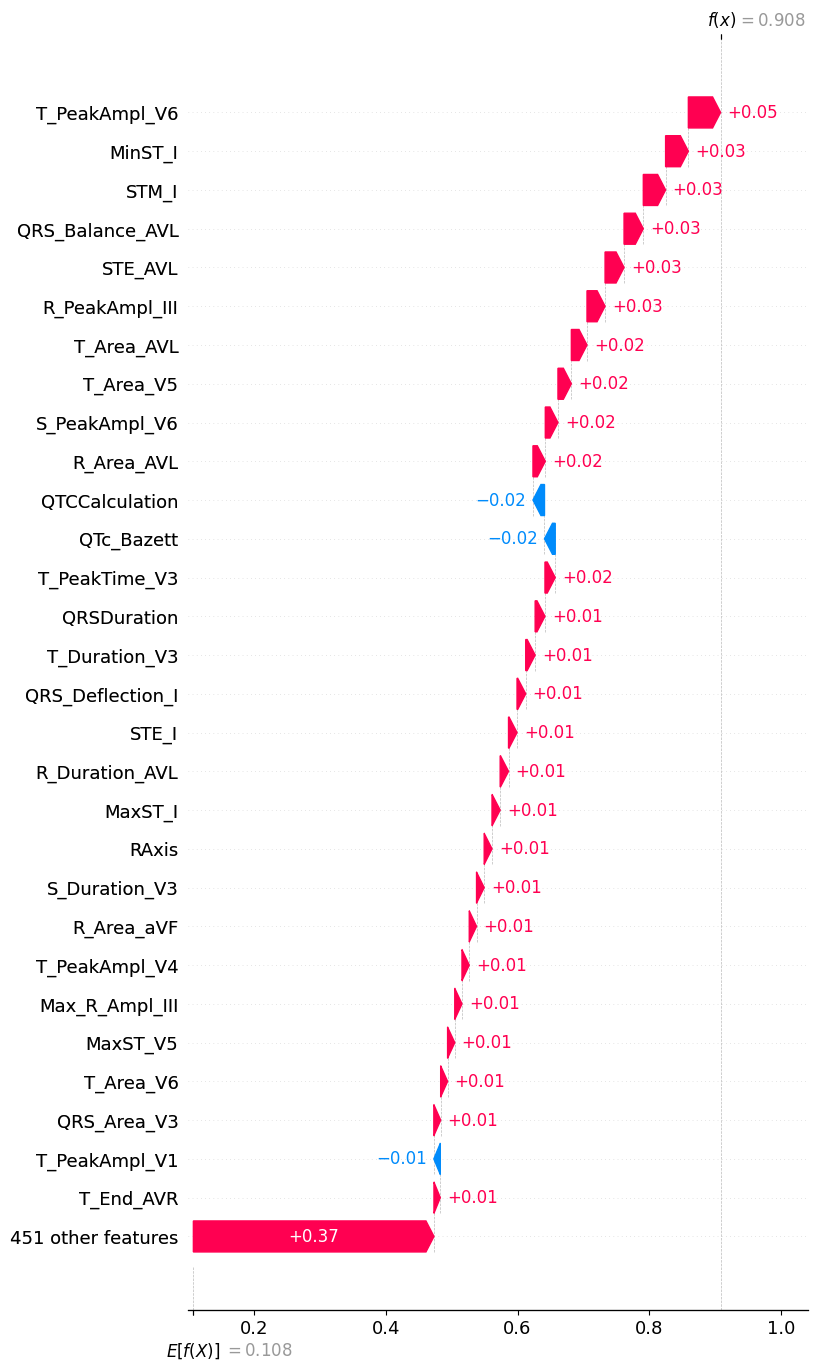

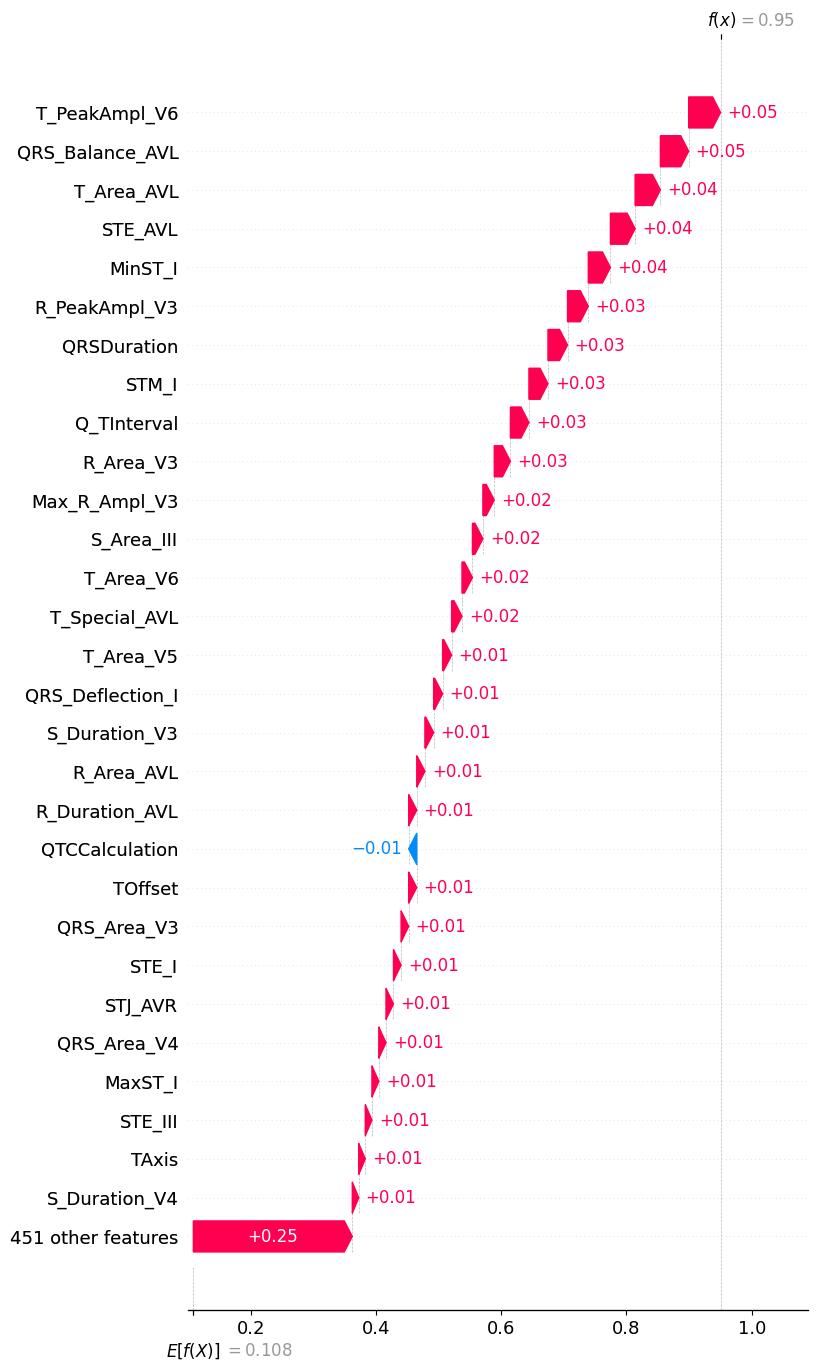

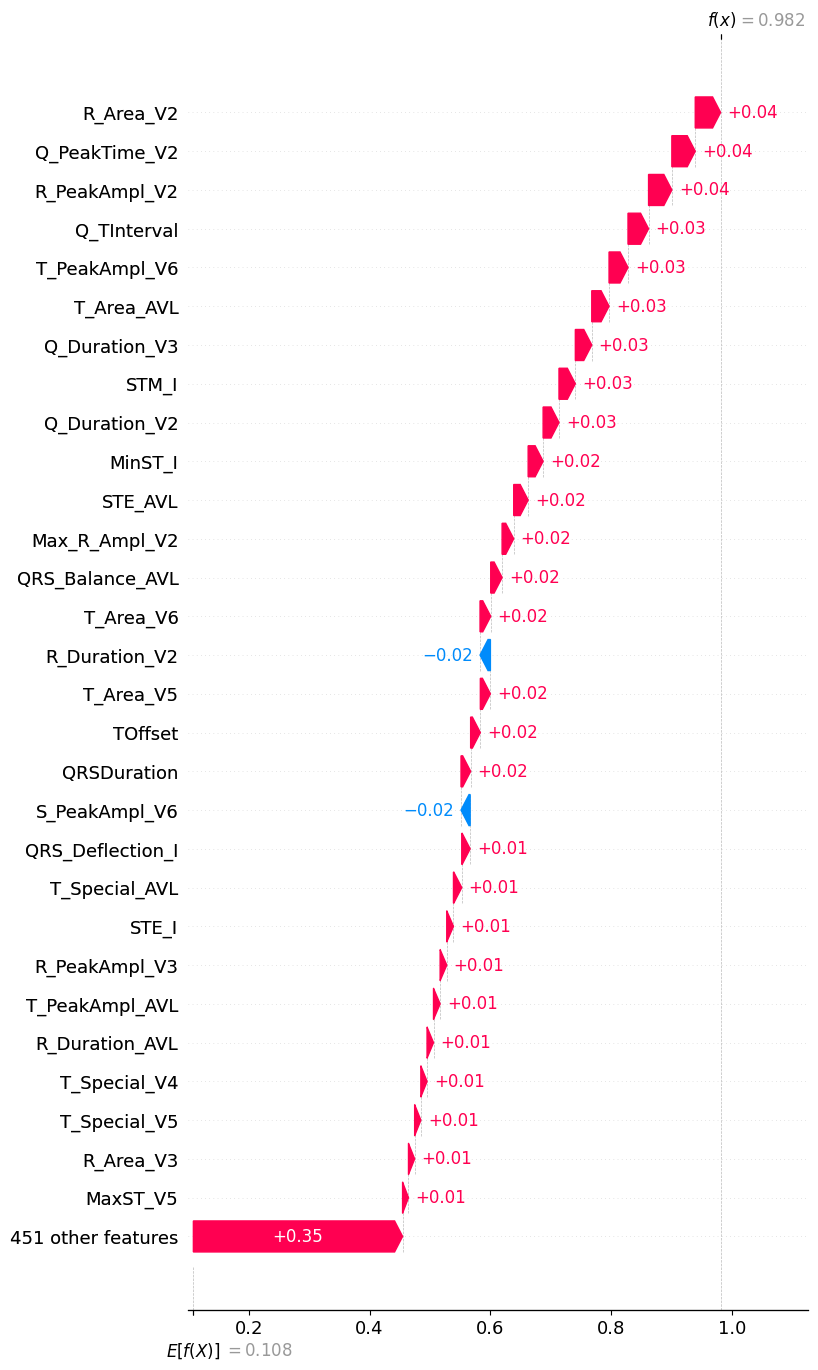

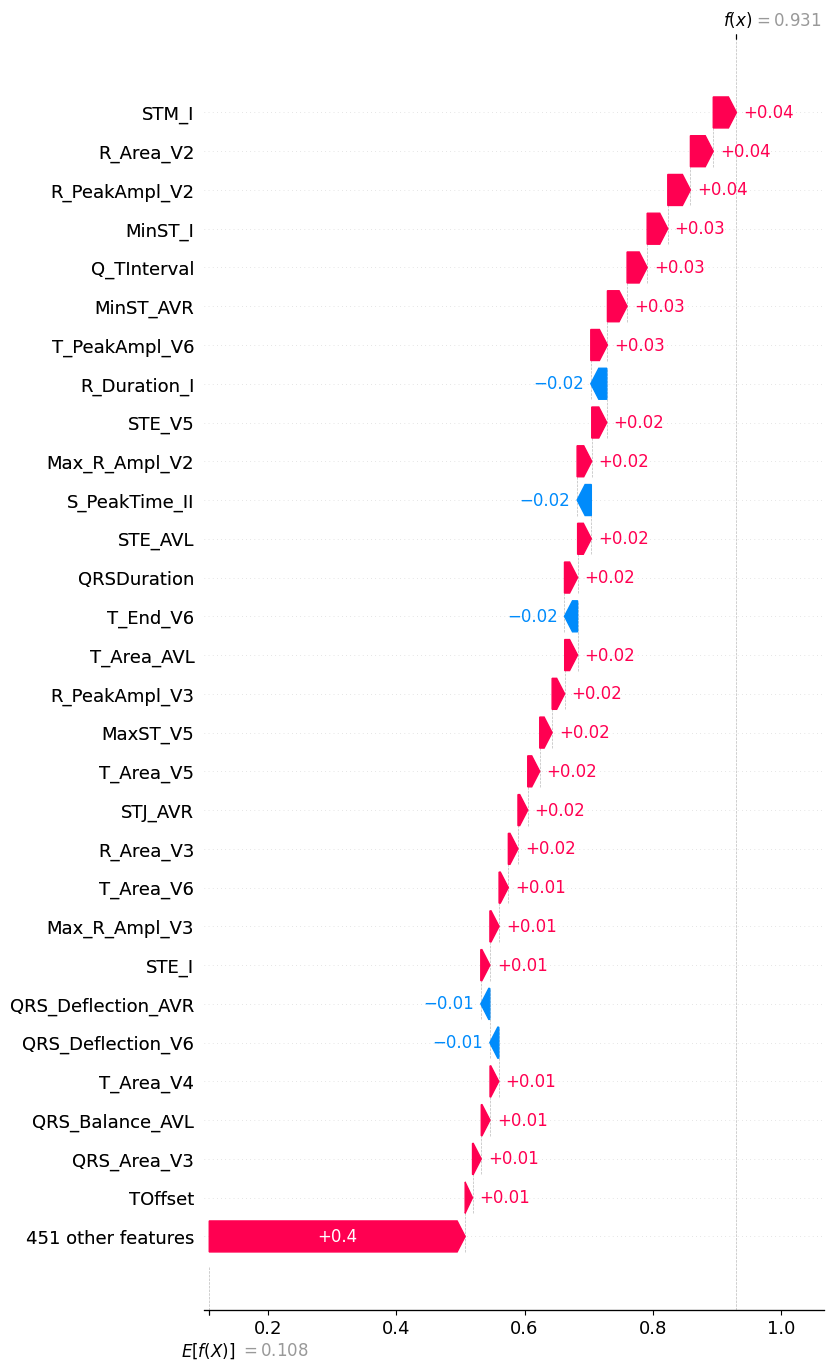

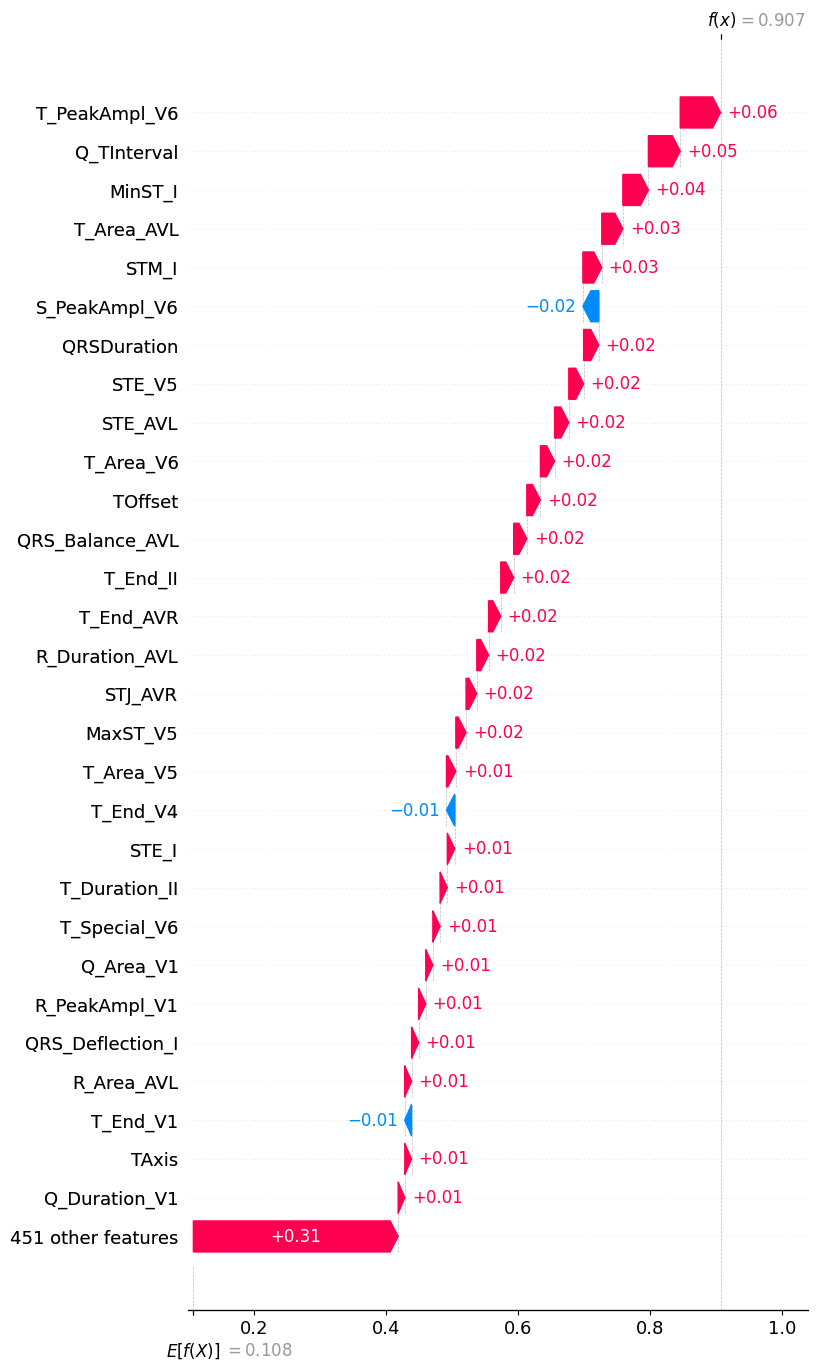

In [84]:
for i in range(len(shap_values_fn_specific)):
    shap.plots._waterfall.waterfall_legacy(
        explainer.expected_value,
        shap_values_fn_specific[i],
        feature_names=df_fn_records_clean.drop(columns = ['PatientID']).columns,
        max_display=30
    )

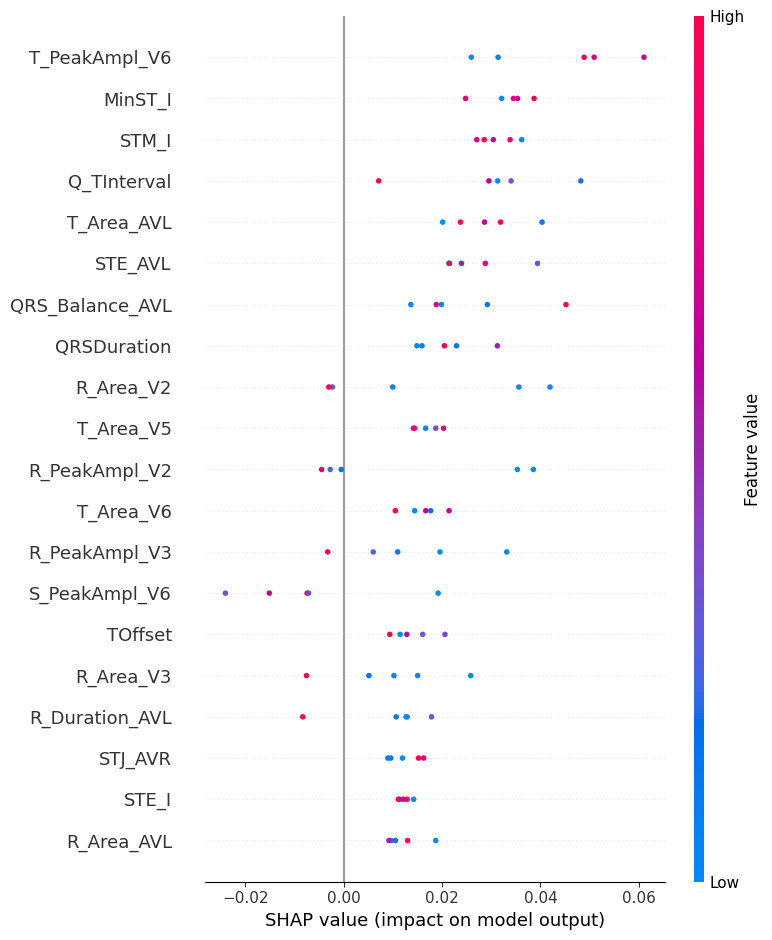

In [85]:
shap.summary_plot(shap_values_fn_specific, df_fn_records_clean.drop(columns=["PatientID"]))


 92%|==================  | 262/286 [00:11<00:01]           

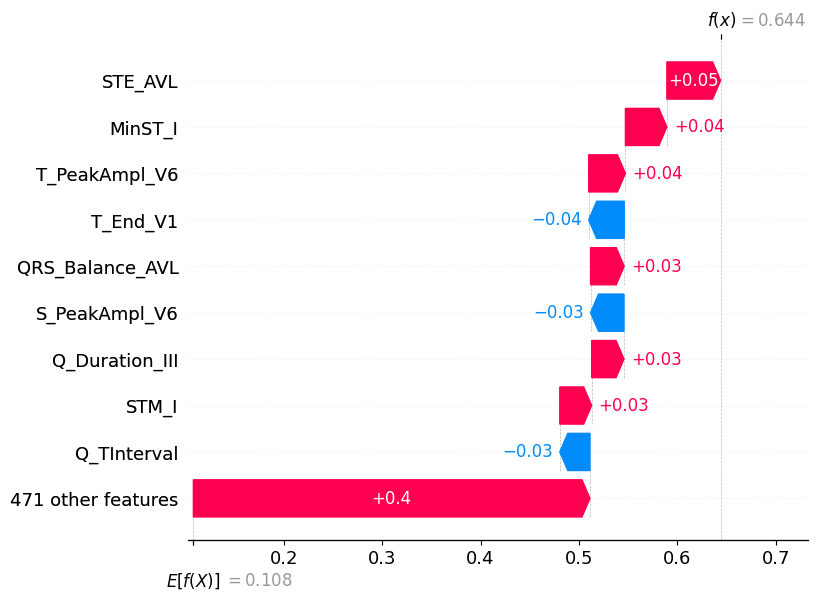

In [86]:
import shap

background = X_train_neg.sample(100, random_state=42)

# Create the explainer with reference data
explainer = shap.TreeExplainer(
    model_neg,
    data=background,
    model_output='probability',
    feature_perturbation='interventional'
)

# Now generate SHAP values without error
shap_values = explainer.shap_values(X_test_neg)

# SHAP values for FPs and FNs in the positive model
shap_values_fp = explainer.shap_values(X_fp_neg)
shap_values_fn = explainer.shap_values(X_fn_neg)

shap.initjs()
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values_fp[0], feature_names=X_fp_neg.columns)


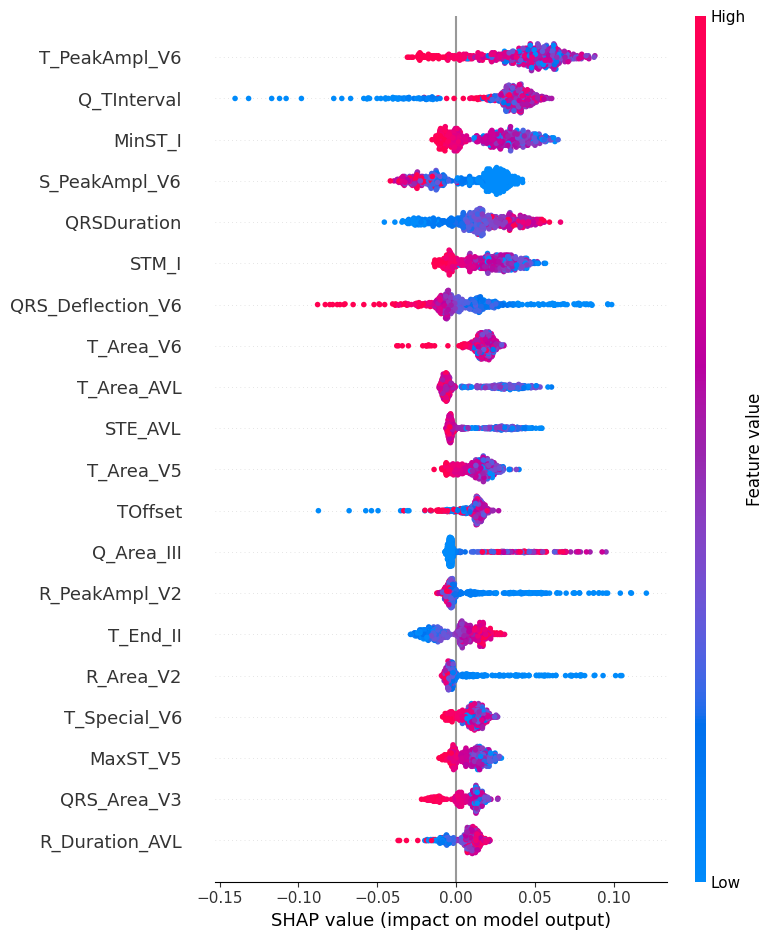

In [87]:
shap.summary_plot(shap_values_fp, X_fp_neg)

 94%|=================== | 269/286 [00:11<00:00]           

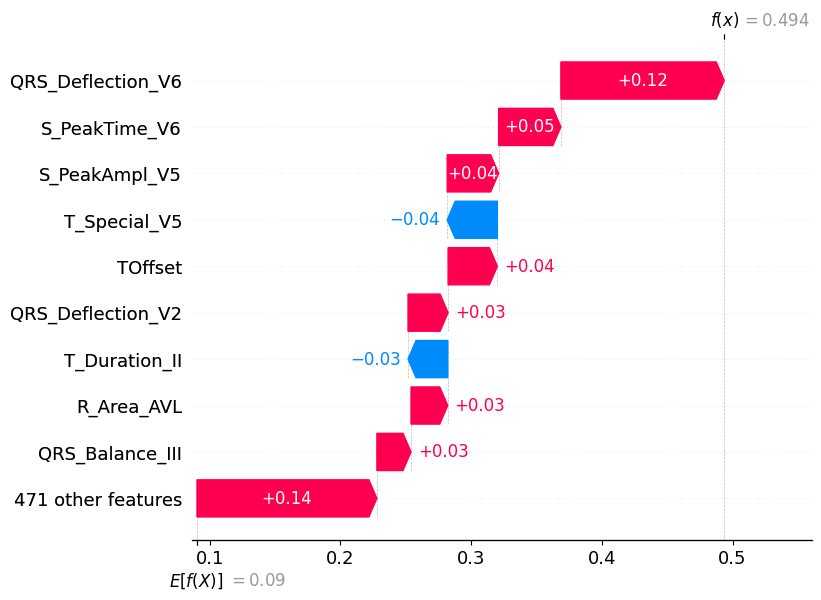

In [88]:
import shap

background = X_train_neg.sample(100, random_state=42)

# Create the explainer with reference data
explainer = shap.TreeExplainer(
    model_pos,
    data=background,
    model_output='probability',
    feature_perturbation='interventional'
)

# Now generate SHAP values without error
shap_values = explainer.shap_values(X_test_neg)

# SHAP values for FPs and FNs in the positive model
shap_values_fp = explainer.shap_values(X_fp_neg)
shap_values_fn = explainer.shap_values(X_fn_neg)

shap.initjs()
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values_fn[0], feature_names=X_fn_neg.columns)


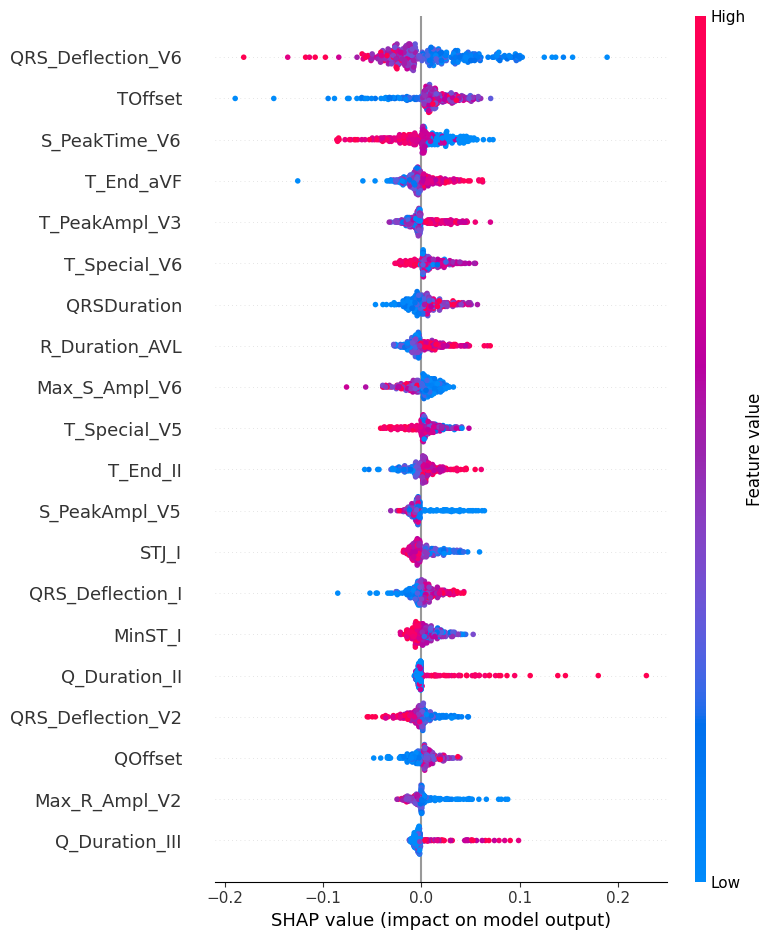

In [89]:
shap.summary_plot(shap_values_fn, X_fn_neg)

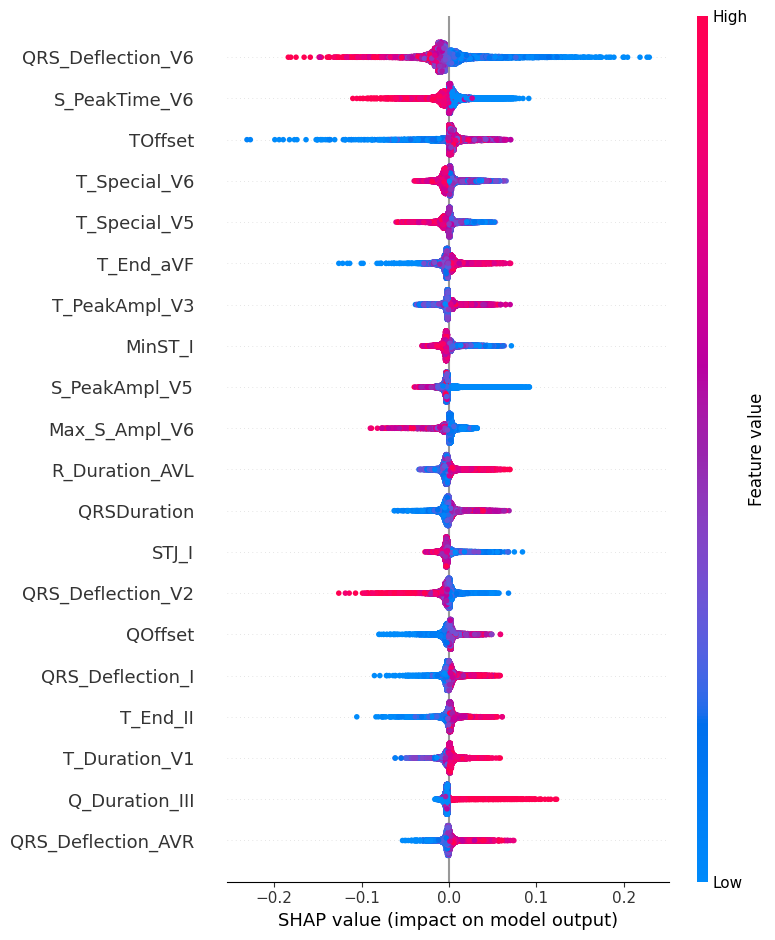

In [90]:
shap.summary_plot(shap_values, X_test_neg)

In [91]:
# import matplotlib.pyplot as plt

# feature = 'PFull_Area_I'
# plt.hist(X_test_neg[feature], bins=50, alpha=0.5, label='All 12SL Positives')
# plt.axvline(X_fp_neg[feature].mean(), color='red', label='FP Mean')
# plt.axvline(X_fn_neg[feature].mean(), color='green', label='FN Mean')
# plt.legend()
# plt.title(f'Distribution of {feature}')
# plt.show()

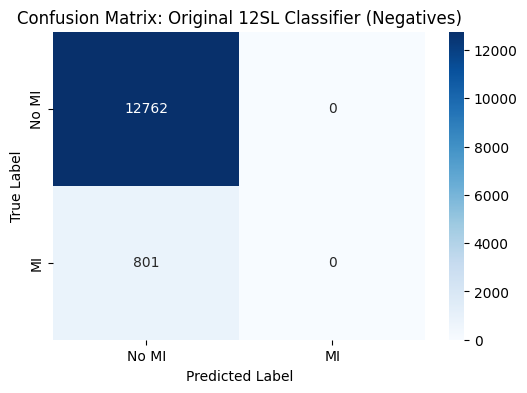

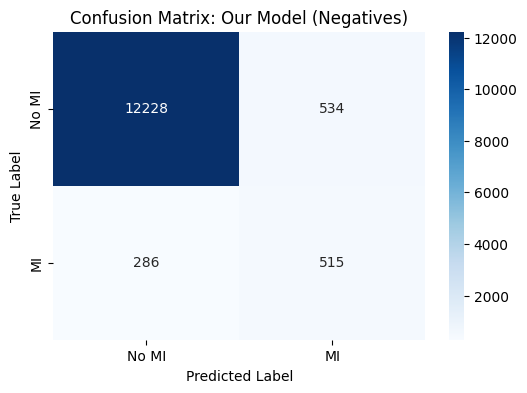

In [92]:
#confusion matrix 12SL (no model)

cm = confusion_matrix(y_test_neg, y_12SL_neg)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["No MI", "MI"], yticklabels=["No MI", "MI"])
plt.title("Confusion Matrix: Original 12SL Classifier (Negatives)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#confusion matrix (from model)

cm = confusion_matrix(y_test_neg, y_pred_neg)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["No MI", "MI"], yticklabels=["No MI", "MI"])
plt.title("Confusion Matrix: Our Model (Negatives)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Baseline Sensitivity (Recall): 0.0
Baseline Precision (PPV): 0.0
Model Sensitivity (Recall): 0.6429463171036205
Model Precision (PPV): 0.4909437559580553


c:\Users\Sam\Downloads\StrokeOfLuck\stroke-of-luck\ebm_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


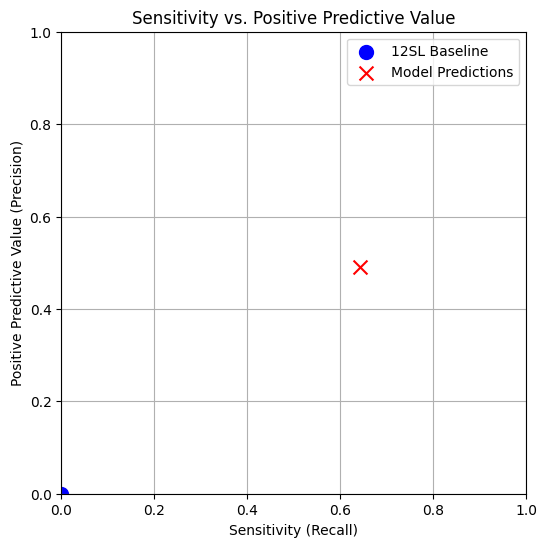

In [93]:
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score

y_true = y_test_neg  # Ground truth for positive subset
baseline_pred = y_12SL.loc[y_test_neg.index]  # 12SL classifier predictions for the same subset
model_pred = y_pred_neg  # Predictions from your trained model

sensitivity_baseline = recall_score(y_true, baseline_pred)
precision_baseline = precision_score(y_true, baseline_pred)

sensitivity_model = recall_score(y_true, model_pred)
precision_model = precision_score(y_true, model_pred)

print("Baseline Sensitivity (Recall):", sensitivity_baseline)
print("Baseline Precision (PPV):", precision_baseline)
print("Model Sensitivity (Recall):", sensitivity_model)
print("Model Precision (PPV):", precision_model)

plt.figure(figsize=(6,6))
plt.scatter(sensitivity_baseline, precision_baseline, 
            label='12SL Baseline', color='blue', marker='o', s=100)
plt.scatter(sensitivity_model, precision_model, 
            label='Model Predictions', color='red', marker='x', s=100)

plt.xlabel('Sensitivity (Recall)')
plt.ylabel('Positive Predictive Value (Precision)')
plt.title('Sensitivity vs. Positive Predictive Value')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


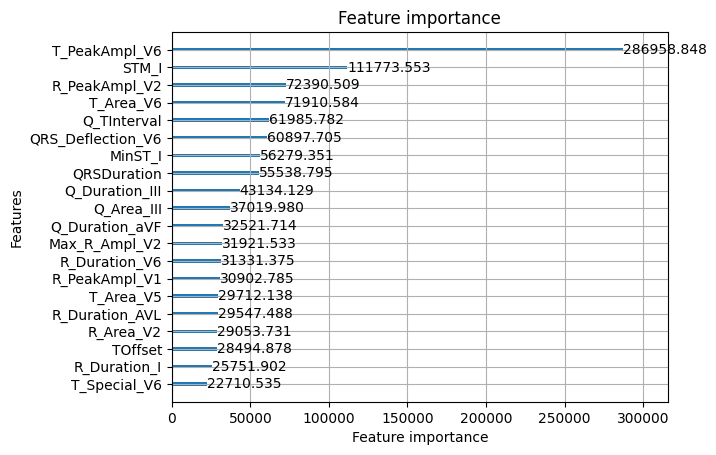

In [94]:
booster = model_neg.booster_
importances = booster.feature_importance(importance_type='split')
feature_names = booster.feature_name()

lgb.plot_importance(booster, importance_type='gain', max_num_features=20)
plt.show()


Baseline Sensitivity (Recall): 0.4974905897114178
Baseline Precision (PPV): 0.4171488690163072
Combined Model Sensitivity (Recall): 0.7089084065244667
Combined Model Precision (PPV): 0.601063829787234


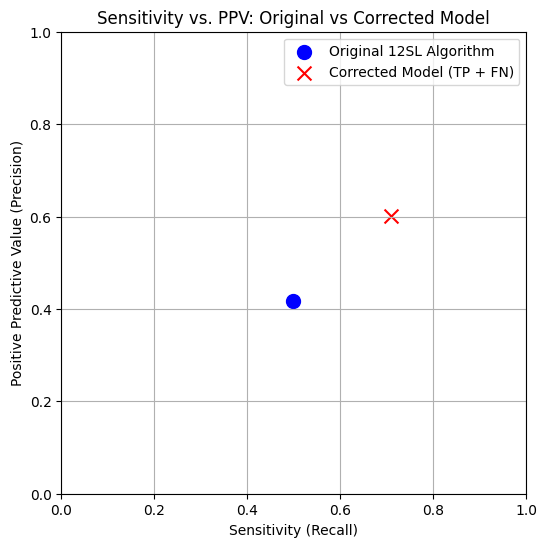

In [95]:
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score

#Compute performance for the original algorithm (MI_12SL)
y_true = y_test
baseline_pred = y_12SL 

sensitivity_baseline = recall_score(y_true, baseline_pred)
precision_baseline = precision_score(y_true, baseline_pred)

#Generate Combined Model Predictions
y_pred_pos = model_pos.predict(X_test_pos)
y_pred_neg = model_neg.predict(X_test_neg)

# Merge the corrected predictions into a single output
y_pred_combined = y_12SL.copy()  # original MI_12SL predictions
y_pred_combined.loc[X_test_pos.index] = y_pred_pos  # Replace with TP model results
y_pred_combined.loc[X_test_neg.index] = y_pred_neg  # Replace with FN model results

#Compute performance for the Combined Model
sensitivity_combined = recall_score(y_true, y_pred_combined)
precision_combined = precision_score(y_true, y_pred_combined)

print("Baseline Sensitivity (Recall):", sensitivity_baseline)
print("Baseline Precision (PPV):", precision_baseline)
print("Combined Model Sensitivity (Recall):", sensitivity_combined)
print("Combined Model Precision (PPV):", precision_combined)

plt.figure(figsize=(6,6))
plt.scatter(sensitivity_baseline, precision_baseline, 
            label='Original 12SL Algorithm', color='blue', marker='o', s=100)
plt.scatter(sensitivity_combined, precision_combined, 
            label='Corrected Model (TP + FN)', color='red', marker='x', s=100)

plt.xlabel('Sensitivity (Recall)')
plt.ylabel('Positive Predictive Value (Precision)')
plt.title('Sensitivity vs. PPV: Original vs Corrected Model')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()
